In [1]:
# Running on GPU?
import setGPU

setGPU: Setting GPU to: 0


# Drift Tubes Digi Occupancy Anomaly Problem with Autoencoders

<b>Goal</b><br>
This exercise examines if there is more information about anomalies in occupancy data.
<br>

<b>Assumption</b><br>
The chambers behave similarly depending on their position in the detector. For example the behavior of chambers in wheel 0 will be different than chambers in wheel -1
<br>

<b>Method</b><br>
Autoencoder is going to be stacked on top of the CNN model to spot strange unusual occupancy plots. The anomaly score will be linked to the usual behavior of the chamber.

In [2]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model
from keras import backend as K

from scipy import misc

from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc

Using TensorFlow backend.


In [3]:
# Presentation

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = False
matplotlib.rcParams["axes.spines.bottom"] = False
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

color_palette = ["#F44336", "#9C27B0", "#3F51B5", "#03A9F4", "#009688",
                 "#8BC34A", "#FFC107", "#FF5722", "#9E9E9E"]

In [4]:
# Data folder

data_directory = "../data"
keras_model = "../model_keras/convolution.h5"

## Data preparation

Load occupancy data to the dataframe.

In [5]:
runs = [273158, 273730, 274388, 274422, 274968, 274969, 275310, 275311,
        275847, 275890, 276244, 276283, 276384, 276587, 276775, 276776,
        276950, 278509, 278820, 278822, 279694, 279766, 279794, 280018,
        281693, 281727, 281976, 282735, 282814, 276582, 272011, 272012,
        272014, 272017, 272021, 272774, 284044, 284043, 284042, 284041,
        302634, 302635, 304737, 304738, 304739, 304740]

test_run = [302634, 302635, 304737, 304738, 304739, 304740]
train_runs = [r for r in runs if r not in test_run]
   
drift_tubes_layers = pd.DataFrame()

for run in runs:
    path = "%s/%s.json" % (data_directory, run)
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);

In [6]:
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(np.array)

Use median polling to remove extreme values (remove noise). This will affect scaling, autoencoder bahavior and eventually the results.

In [7]:
SMOOTH_FILTER_SIZE = 3

def median_polling(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(median_polling)

Use bilinear interpolation to resize all the data samples to match the requirement of CNN:

In [8]:
SAMPLE_SIZE = min(drift_tubes_layers["content_smoothed"].apply(len))

def resize_occupancy(layer):
    return misc.imresize(np.array(layer).reshape(1, -1), (1, SAMPLE_SIZE), interp="bilinear", mode="F").reshape(-1)

drift_tubes_layers["content_resized"] = drift_tubes_layers["content_smoothed"].apply(resize_occupancy)

Evaluate if the layer is faulty using trained CNN model.

In [9]:
CNN_MODEL = load_model(keras_model)
SAMPLE_SIZE = min(drift_tubes_layers["content"].apply(len))

def scale_occupancy(layer):
    """Scales the layer to the <0, 1> range"""
    layer = layer.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(layer)
    return scaler.transform(layer).reshape(1, -1)

def score_occupancy(layer):
    """Predicts if layer is faulty or good"""
    layer = resize_occupancy(layer)
    layer = scale_occupancy(layer)
    return np.argmax(CNN_MODEL.predict(layer.reshape(-1, 47, 1)))

drift_tubes_layers["score"] = drift_tubes_layers["content"].apply(score_occupancy)

We scale the hits, so that all occupancies stay in -1 to 1 range within a <b>run</b>. This way ratios between the chamber occupancies are still there.

In [116]:
def get_occypancy_histogram(values, bins):
    """Plots the distribution of hits per channel"""
    plt.hist(np.array(values).flatten(), bins)
    plt.title("Distribution of number of hits per cell")
    plt.xlabel("Hits per cell")
    plt.ylabel("Number of cells")
    plt.yscale("log", nonposy="clip")
    plt.show();

def scaler_per_run(data_points):
    """Returns scaler for each run"""
    scalers = {}
    for run in runs:
        values_per_run = drift_tubes_layers[drift_tubes_layers.run == run][data_points].values
        values_per_run = np.concatenate(values_per_run).reshape(-1, 1)
        scalers[run] = MinMaxScaler(feature_range=(0, 1)).fit(values_per_run)            
    return scalers

def scale_layer(hits_array, scaler):
    """Sales hits by a given scaler."""
    return scaler.transform(hits_array.reshape(-1, 1)).reshape(-1).tolist()

def scale_dataset(new_column, old_column):
    """Scales the dataset"""
    scalers = scaler_per_run(old_column)
    drift_tubes_layers[new_column] = drift_tubes_layers.apply(lambda row: scale_layer(row[old_column], scalers[row["run"]]), axis=1)
    drift_tubes_layers[new_column] = drift_tubes_layers[new_column].apply(np.array)

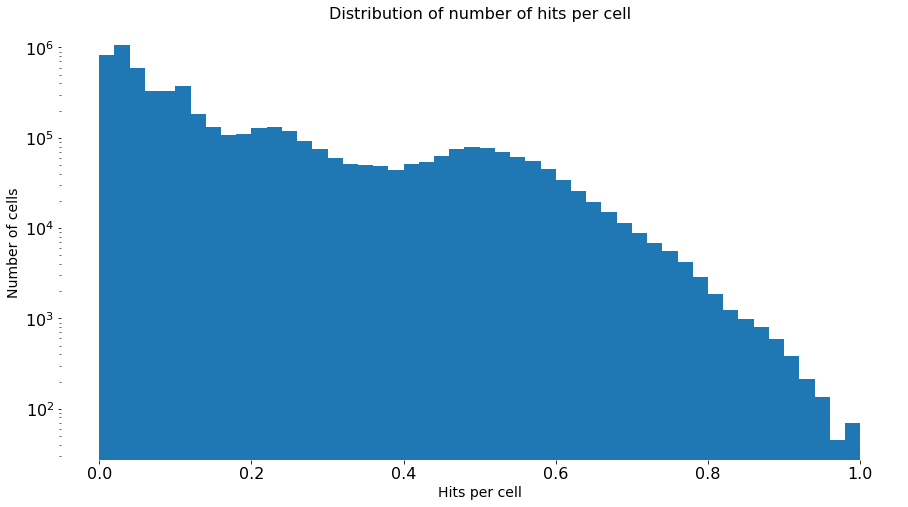

In [117]:
scale_dataset("content_scaled", "content_resized")
get_occypancy_histogram(drift_tubes_layers["content_scaled"].values.tolist(), 50)

The zipf distribution of hits will influance our metrics for detecting anomalies. To account for this, let's change the distribution.

In [118]:
def change_distribution(x):
    """Changes distribution of x"""
    return np.power(np.array(x).flatten(), 0.3)

drift_tubes_layers["content_powered"] = drift_tubes_layers["content_resized"].apply(change_distribution)

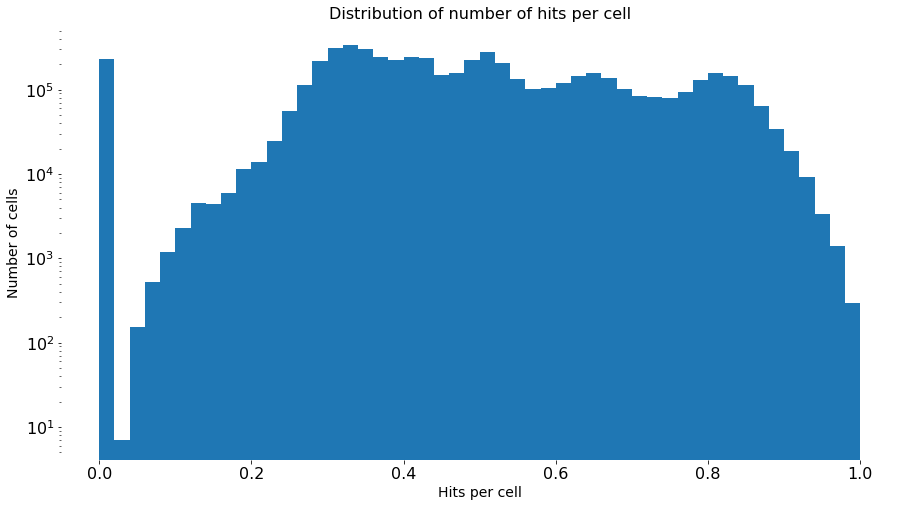

In [119]:
scale_dataset("content_powered_scaled", "content_powered")
get_occypancy_histogram(drift_tubes_layers["content_powered_scaled"].values.tolist(), 50)

Finally, let's combine per layer data so we have a matrix of size 12x45 corresponding to a chamber data

In [120]:
SAMPLE_SIZE = 45
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 5):
            for sector in range(1, 15):

                chamber = drift_tubes_layers[(drift_tubes_layers.run == run) &
                                             (drift_tubes_layers.wheel == wheel) &
                                             (drift_tubes_layers.station == station) &
                                             (drift_tubes_layers.sector == sector)].sort_values("layer",
                                                                                                ascending=1)
                if not len(chamber):
                    continue

                occupancy_raw = [layer.tolist() for layer in chamber["content"]]
                occupancy_smoothed = [layer.tolist() for layer in chamber["content_smoothed"]]

                occupancy_resized = np.concatenate(
                    chamber["content_resized"].values).reshape(-1, SAMPLE_SIZE)
                occupancy_scaled = np.concatenate(
                    chamber["content_scaled"].values).reshape(-1, SAMPLE_SIZE)
                occupancy_powered_scaled = np.concatenate(
                    chamber["content_powered_scaled"].values).reshape(-1, SAMPLE_SIZE)
                
                extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))
                extended_size_raw = max((len(_) for _ in occupancy_raw))

                for index, layer in enumerate(occupancy_raw):
                    layer.extend([np.nan]*(extended_size_raw-len(layer)))
                    occupancy_raw[index] = layer

                for index, layer in enumerate(occupancy_smoothed):
                    layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                    occupancy_smoothed[index] = layer
                   
                score = sum(chamber.score.values)

                data = {"run": run,
                        "wheel": wheel,
                        "station": station,
                        "sector": sector,
                        "score": score,
                        "content_powered_scaled": occupancy_powered_scaled,
                        "content_scaled": occupancy_scaled,
                        "content_resized": occupancy_resized,
                        "content_smoothed": np.reshape(occupancy_smoothed,
                                                       (len(chamber), extended_size_smoothed)),
                        "content_raw": np.reshape(occupancy_raw,
                                                  (len(chamber), extended_size_raw))}

                drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data), ignore_index=True)

### Visualizing processing pipeline

Here are some examples of one chamber (sample) on every step of data preparation:

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_occupancy_hitmap(data, title):
    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(['1','5','9'])
    ax.set_yticks([0, 4, 8])
    
    plt.xlabel("Channel")
    plt.ylabel("Layer")
    
    im = ax.imshow(data, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(data)), np.max(np.nan_to_num(data))])
    plt.title(title)   
    plt.show();
    
def get_title(title, show):
    return ("%s Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
            (title, int(show.run), show.wheel, show.station, show.sector))

def visualize_preprocessing(show):
    plot_occupancy_hitmap(show.content_raw, get_title("Raw", show))
    plot_occupancy_hitmap(show.content_smoothed, get_title("Smoothed", show))
    plot_occupancy_hitmap(show.content_resized, get_title("Reshaped", show))
    plot_occupancy_hitmap(show.content_scaled, get_title("Scaled", show))
    plot_occupancy_hitmap(show.content_powered_scaled, get_title("Powered", show))

#### Chamber with no problems

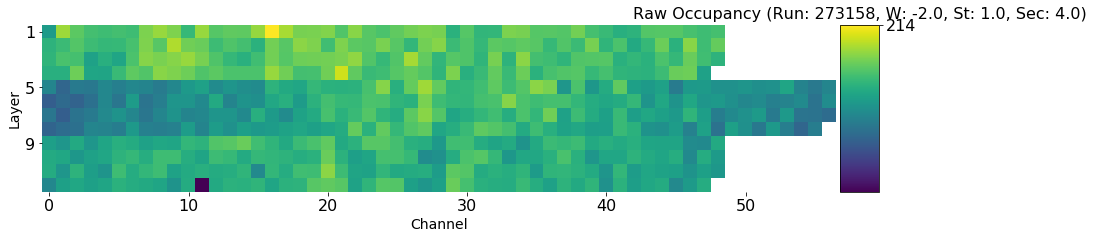

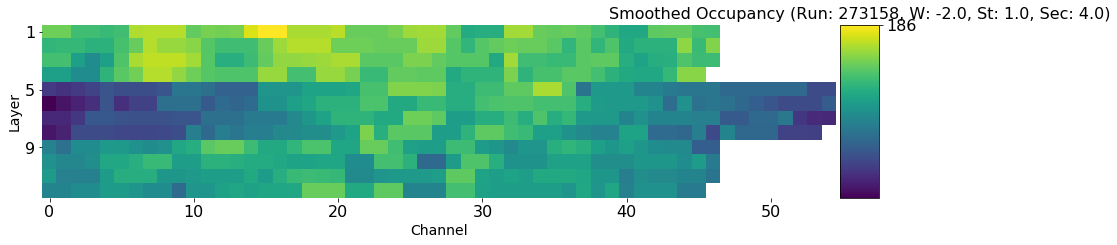

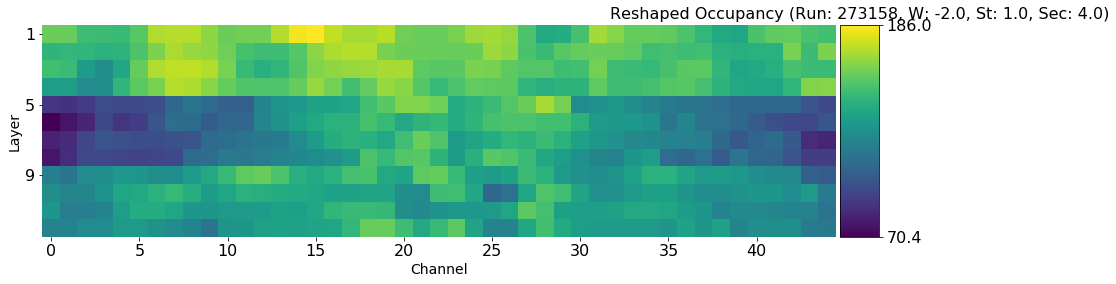

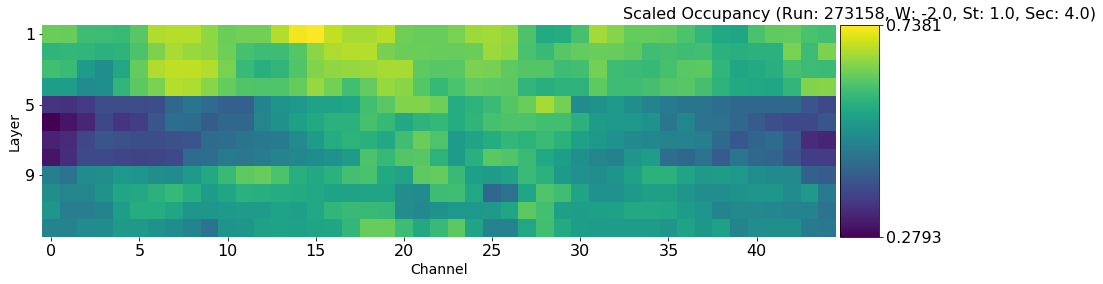

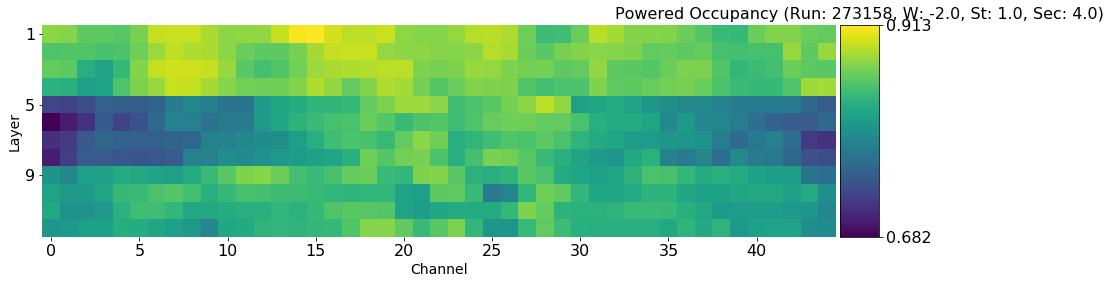

In [122]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[0])

#### Chamber with one faulty layer

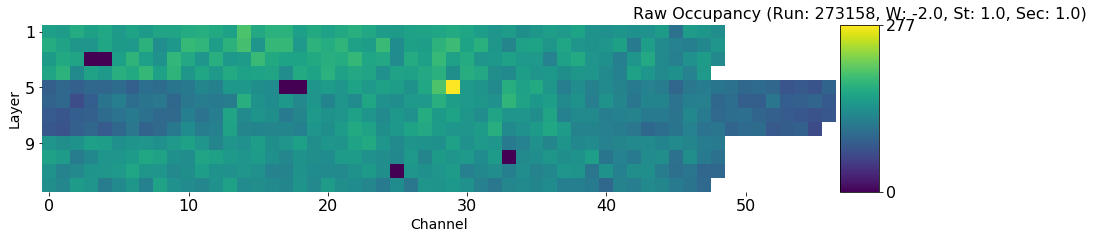

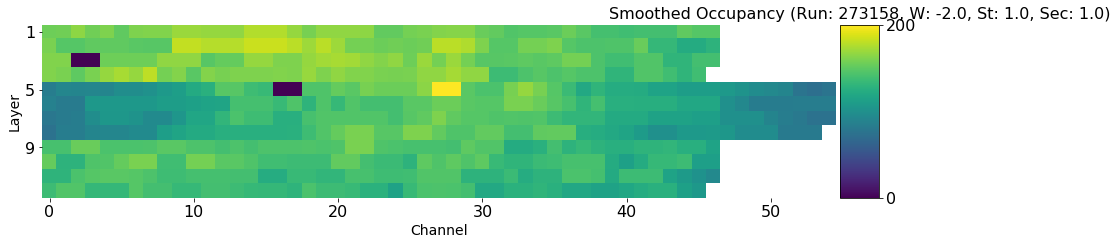

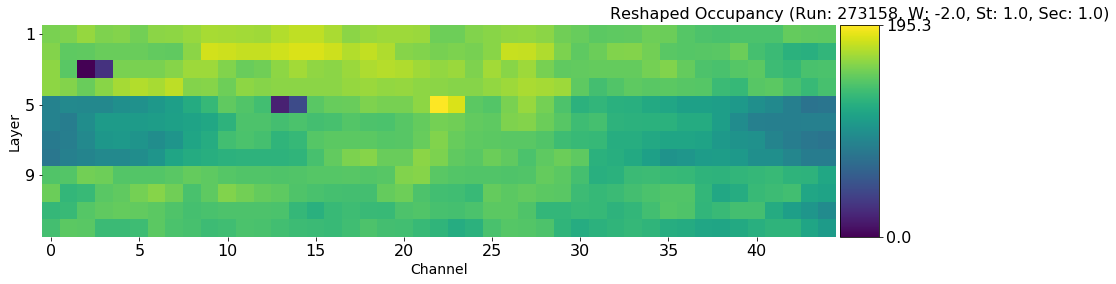

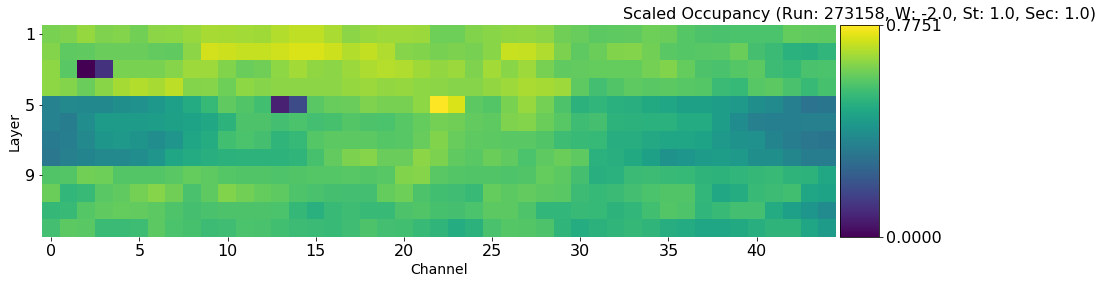

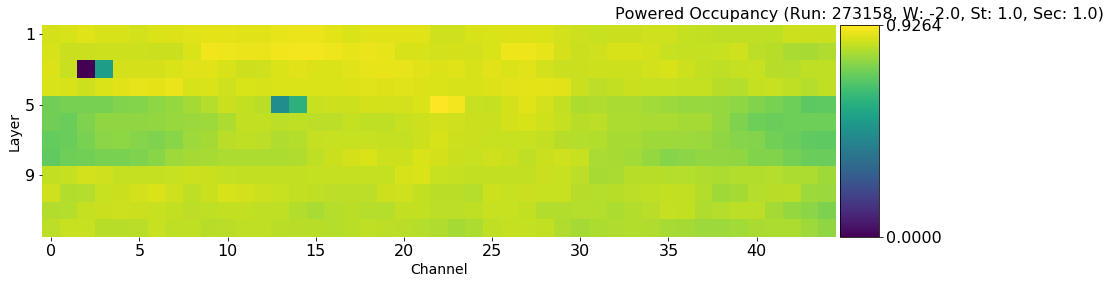

In [123]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 1].iloc[0])

#### Chamber with one faulty superlayer (4 layers)

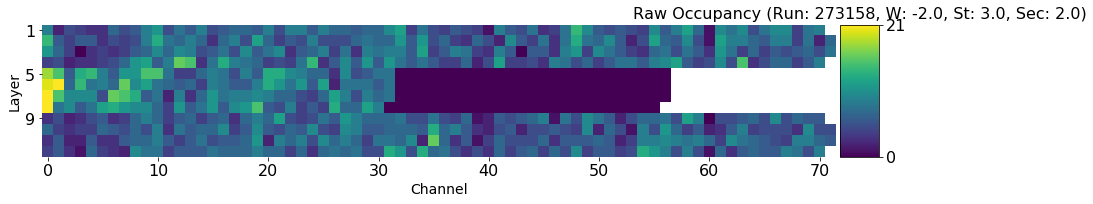

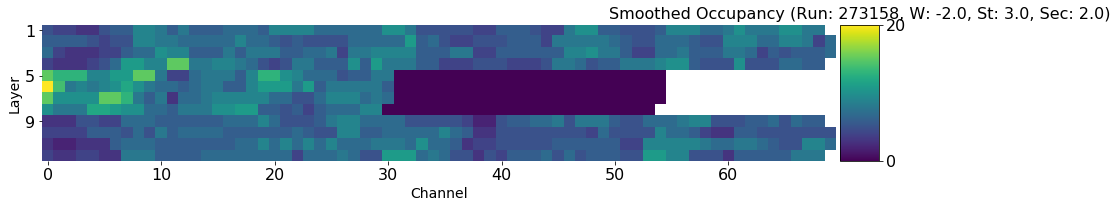

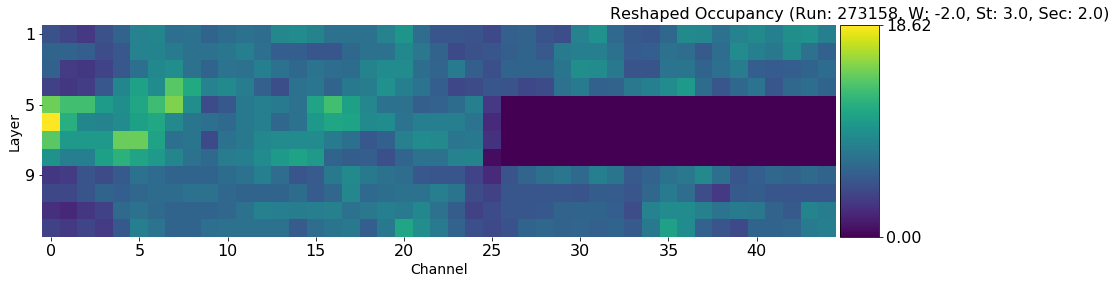

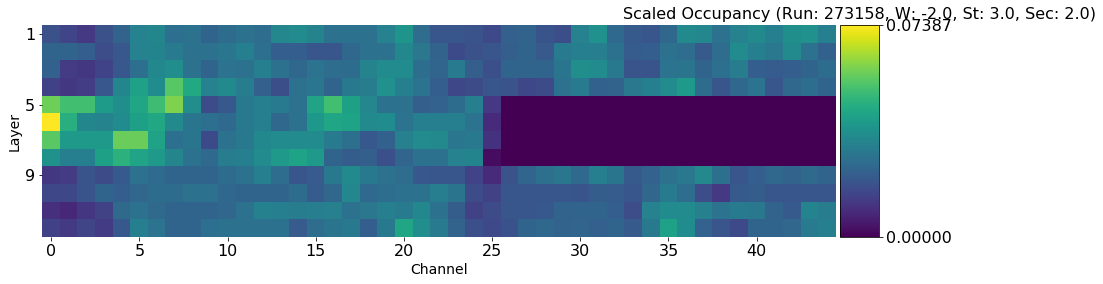

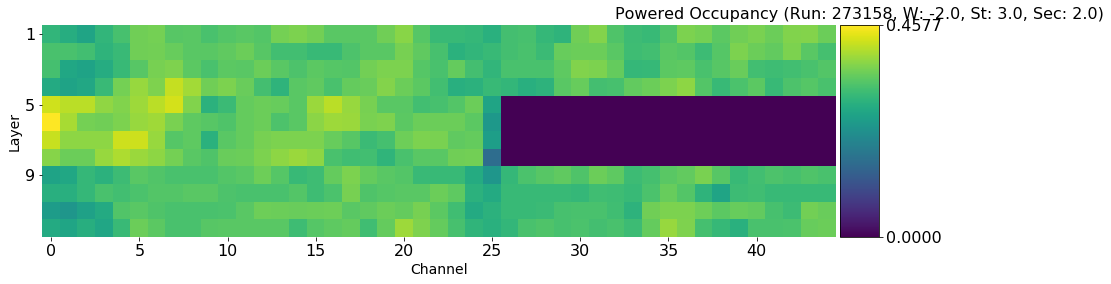

In [124]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 4].iloc[0])

#### Chamber with all faulty layers

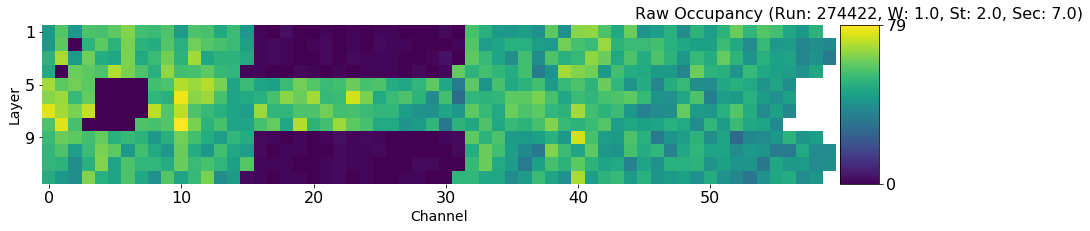

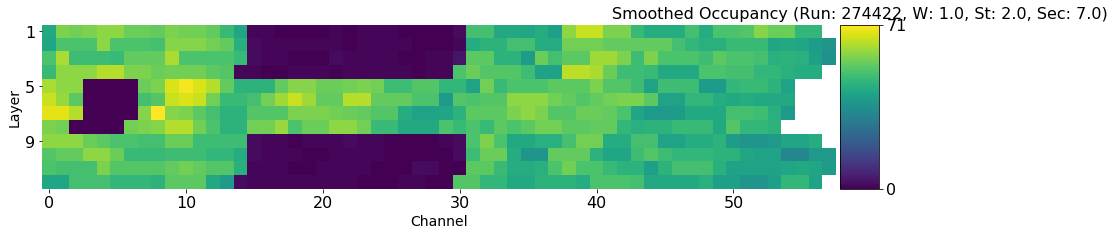

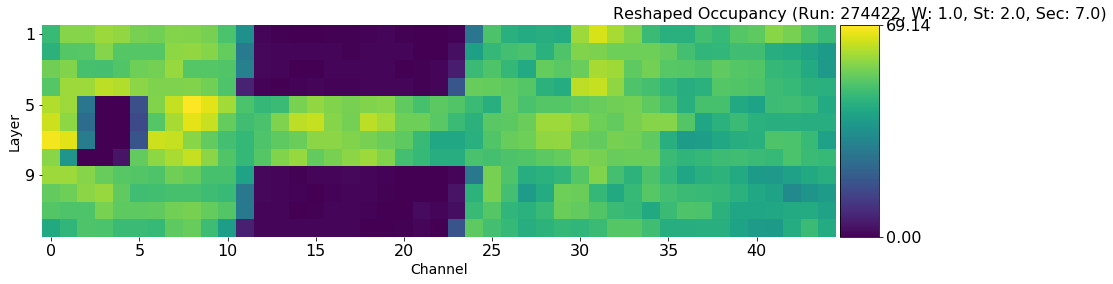

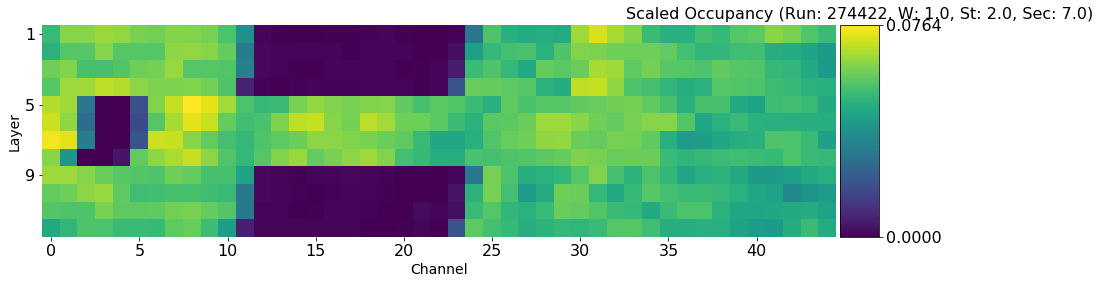

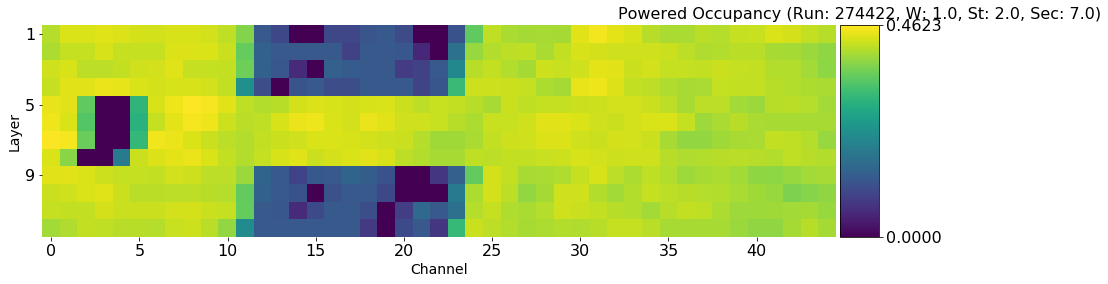

In [125]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[0])

## Add scores

According to information provided by experts:<br>
<b>Run 302634</b>: MB4 and MB1 in S3-S4-S5 of WP2, WM2 and W00 have the correct HV; all the other chambers have the problem in phi2 L1<br>
<b>Run 302635</b>: all ok<br>
<b>Runs 304737, 304738, 304739, 304740</b>: all the chambers with one layer (usually phi2 layer1, layer 9) at 3450V (hit efficiency ~70%)

In [126]:
def hit_per_layer(run, step):
    samples = drift_tubes_chambers[(drift_tubes_chambers["run"] == run) &
                                   (drift_tubes_chambers["score"] == 0) &
                                   (drift_tubes_chambers["station"] != 4)]
    foo = np.array([])
    for _ in samples[step].values:
        foo = np.append(foo, np.nansum(_, axis=1))
    
    return np.mean(foo.reshape(-1, 12),axis=0)

print("Raw, percentage:")
for run in test_run:
    errors = hit_per_layer(run, "content_raw")
    errors = errors / sum(errors)
    print("%s: %s" %(run, [str(round(e, 2)) for e in errors]))

print("Absolute after preprocessing:")
for run in test_run:
    hits = hit_per_layer(run, "content_powered_scaled")
    print("%s: %s" %(run, [str(round(e, 1)) for e in hits]))

Raw, percentage:
302634: ['0.1', '0.1', '0.1', '0.09', '0.09', '0.09', '0.09', '0.09', '0.02', '0.08', '0.08', '0.08']
302635: ['0.09', '0.09', '0.09', '0.09', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08']
304737: ['0.09', '0.09', '0.09', '0.09', '0.08', '0.08', '0.08', '0.08', '0.06', '0.08', '0.08', '0.08']
304738: ['0.09', '0.09', '0.09', '0.09', '0.08', '0.08', '0.08', '0.08', '0.06', '0.08', '0.08', '0.08']
304739: ['0.09', '0.09', '0.09', '0.09', '0.08', '0.08', '0.08', '0.08', '0.06', '0.08', '0.08', '0.08']
304740: ['0.09', '0.09', '0.09', '0.09', '0.08', '0.08', '0.08', '0.08', '0.06', '0.08', '0.08', '0.08']
Absolute after preprocessing:
302634: ['23.6', '23.6', '23.6', '23.5', '23.2', '23.1', '23.0', '23.0', '10.7', '22.9', '22.9', '22.9']
302635: ['23.9', '23.8', '23.8', '23.7', '23.5', '23.4', '23.4', '23.3', '23.1', '23.1', '23.0', '23.1']
304737: ['22.2', '22.1', '22.0', '22.0', '21.7', '21.6', '21.6', '21.5', '19.9', '21.4', '21.3', '21.4']
304738: ['2

Indeed, we can see a decrease of hits in layer 9. Let's add this information to the dataframe

In [127]:
drift_tubes_chambers.loc[:, "voltage_fault"] = np.nan
drift_tubes_chambers.loc[drift_tubes_chambers["run"].isin(test_run), "voltage_fault"] = 1
drift_tubes_chambers.loc[drift_tubes_chambers["run"] == 302635,  "voltage_fault"] = -1
drift_tubes_chambers.loc[(drift_tubes_chambers["run"] == 302634) &
                         (drift_tubes_chambers["station"].isin([1, 4])) &
                         (drift_tubes_chambers["sector"].isin([3, 4, 5])) &
                         (drift_tubes_chambers["wheel"].isin([-2, 0, 2])), "voltage_fault"] = -1

Create combine score of CNN model and voltage fault:

In [128]:
drift_tubes_chambers["combined_score"] = ((drift_tubes_chambers["voltage_fault"] == 1) | 
                                          (drift_tubes_chambers["score"] > 0))*2-1

### Examples of voltage fault (without and with CNN fault)

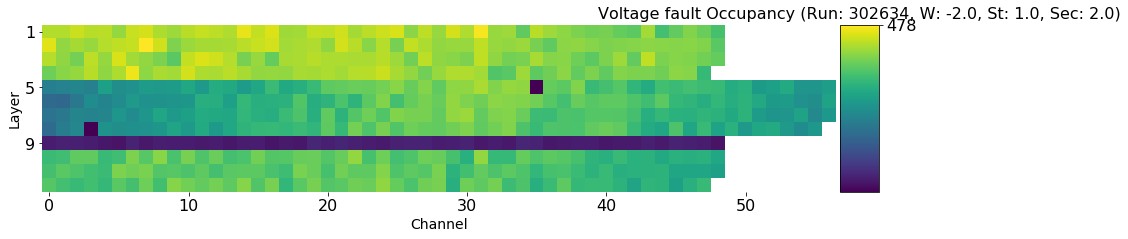

In [129]:
show = drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                            (drift_tubes_chambers["score"] == 0)].iloc[0]
plot_occupancy_hitmap(show.content_raw, get_title("Voltage fault", show))

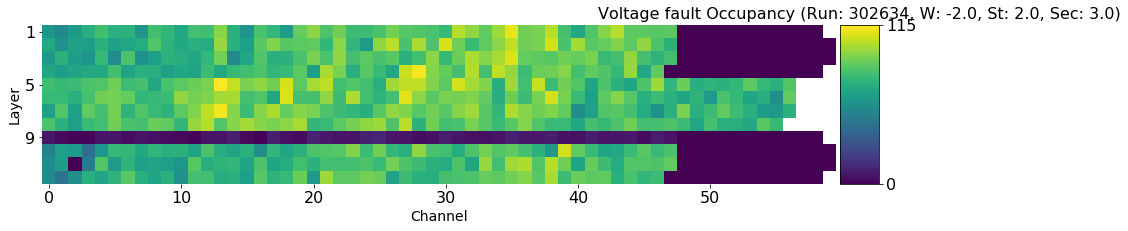

In [130]:
show = drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                            (drift_tubes_chambers["score"] > 4)].iloc[0]
plot_occupancy_hitmap(show.content_raw, get_title("Voltage fault", show))

## Calculate CNN sensitivity wrt. voltage problem

In [131]:
def benchmark(y_true, y_score):
    y_pred = 2*(y_score > 0)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return round(float(tp)/(tp+fn), 2)
    
print("Model sensitivity: %s" % benchmark(drift_tubes_chambers["combined_score"], drift_tubes_chambers["score"]))

Model sensitivity: 0.69


This reports how many chambers having a voltage problem have also a dead region

## Training the model

Let's define a simple convolutional autoencoder.

In [687]:
_input = Input(shape=(12, 45, 1), name='Input_Image')
x = Conv2D(8, (4, 4), padding='same', name='Convolution_A')(_input)
x = LeakyReLU(alpha=0.1)(x)
x = AveragePooling2D((2, 4), padding='same', name='Polling_A')(x)

x = Conv2D(8, (2, 4), padding='same', name='Convolution_B')(x)
x = LeakyReLU(alpha=0.1)(x)
x = AveragePooling2D((2, 4), padding='same', name='Polling_B')(x)

x = Conv2D(8, (3, 3), activation='sigmoid', padding='same', name='Convolution_C')(x)
x = LeakyReLU(alpha=0.1)(x)
x = AveragePooling2D((1, 3), padding='same', name='Polling_C')(x)

x = Conv2D(2, (3, 1), activation='sigmoid', padding='same', name='Convolution_D')(x)
x = LeakyReLU(alpha=0.1)(x)

encoded_max = MaxPooling2D((3, 1), padding='same', name='encoder_max')(x)
encoded_ave = AveragePooling2D((3, 1), padding='same', name='encoder_ave')(x)

x = UpSampling2D((1, 3))(x)
x = Conv2D(8, (1, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((2, 4))(x)
x = Conv2D(8, (2, 4), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((2, 4))(x)
x = Conv2D(3, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
decoded = Conv2D(1, (1, 4), activation='sigmoid', padding='valid')(x)

encoder_max = Model(_input, encoded_max)
encoder_ave = Model(_input, encoded_ave)
autoencoder = Model(_input, decoded)

In [641]:
_input = Input(shape=(12, 45, 1), name='Input_Image')
x = Conv2D(8, (4, 9), padding='same', name='Convolution_A')(_input)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((4, 9), padding='same', name='Polling_A')(x)

x = Conv2D(2, (3, 5), padding='same', name='Convolution_B')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((1, 5), padding='same', name='Polling_B')(x)

x = Conv2D(2, (3, 1), activation='sigmoid', padding='same', name='Convolution_C')(x)
x = LeakyReLU(alpha=0.1)(x)

encoded_max = MaxPooling2D((3, 1), padding='same', name='encoder_max')(x)
encoded_ave = AveragePooling2D((3, 1), padding='same', name='encoder_ave')(x)

x = UpSampling2D((1, 5))(x)
x = Conv2D(8, (1, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((4, 9))(x)
decoded = Conv2D(1, (2, 4), activation='sigmoid', padding='same')(x)

encoder_max = Model(_input, encoded_max)
encoder_ave = Model(_input, encoded_ave)
autoencoder = Model(_input, decoded)

### ConvAE Architecture

In [688]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Image (InputLayer)     (None, 12, 45, 1)         0         
_________________________________________________________________
Convolution_A (Conv2D)       (None, 12, 45, 8)         136       
_________________________________________________________________
leaky_re_lu_173 (LeakyReLU)  (None, 12, 45, 8)         0         
_________________________________________________________________
Polling_A (AveragePooling2D) (None, 6, 12, 8)          0         
_________________________________________________________________
Convolution_B (Conv2D)       (None, 6, 12, 8)          520       
_________________________________________________________________
leaky_re_lu_174 (LeakyReLU)  (None, 6, 12, 8)          0         
_________________________________________________________________
Polling_B (AveragePooling2D) (None, 3, 3, 8)           0         
__________

In [689]:
def plot_loss(data, title):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show();

Training ConvAE. Station 4 has different occupancy shape, so for now we will discard it. We will also exclude all occupancies that are having one or more problematic layers according to CNN model.

Training with 5607 samples.


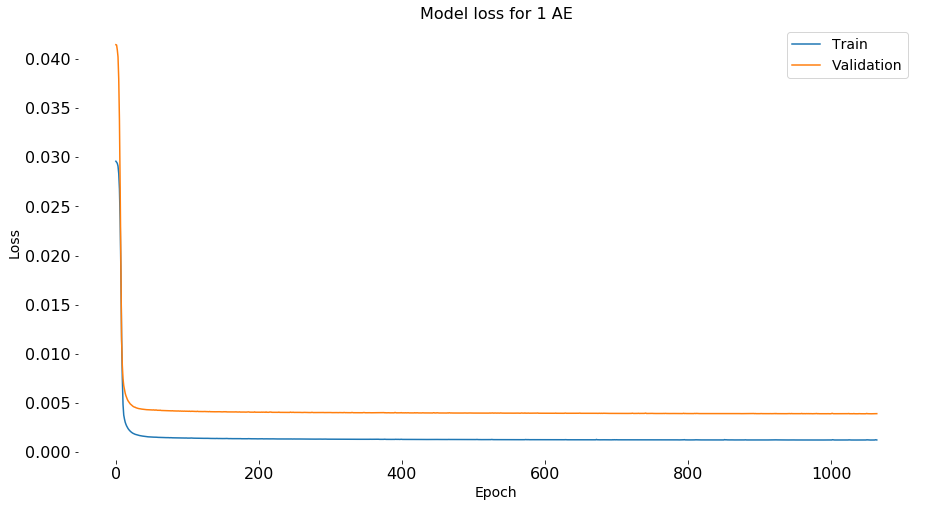

In [690]:
drift_tubes_chambers.loc[:, "score_1_ae"] = np.nan
drift_tubes_chambers.loc[:, "decoded_1_ae"] = np.nan
drift_tubes_chambers.loc[:, "encoded_1_ae_max"] = np.nan
drift_tubes_chambers.loc[:, "encoded_1_ae_ave"] = np.nan

train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                             (drift_tubes_chambers.station != 4) &
                             (drift_tubes_chambers.score == 0)]
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers.station != 4)]

print("Training with %s samples." %(len(train)))

x_train = np.array([])
x_test = np.array([])

for _, ch in train.iterrows(): 
    x_train = np.append(x_train, ch["content_powered_scaled"].reshape(12, 45, 1))

for _, ch in test.iterrows(): 
    x_test = np.append(x_test, ch["content_powered_scaled"].reshape(12, 45, 1))

x_train= np.reshape(x_train, (len(train), 12, 45, 1))
x_test= np.reshape(x_test, (len(test), 12, 45, 1))

autoencoder.compile(optimizer='adam', loss='mse')
early_stopper = EarlyStopping(monitor="val_loss", patience=16, verbose=False, mode="auto")
history = autoencoder.fit(x_train, x_train, epochs=2048, validation_split=0.2,
                          batch_size=512, shuffle=True, verbose=False, callbacks=[early_stopper])

plot_loss(history.history, "Model loss for 1 AE")

decoded_imgs = autoencoder.predict(x_test).reshape(len(test), 12, 45)
mse = np.sum(np.sum((x_test.reshape(len(test), 12, 45) - decoded_imgs) ** 2, axis = 1), axis=1)

drift_tubes_chambers.loc[test.index, "score_1_ae"] = mse
drift_tubes_chambers.loc[test.index, "decoded_1_ae"] = pd.DataFrame({"decoded_1_ae": decoded_imgs.tolist()},
                                                                    index=test.index)
drift_tubes_chambers.loc[test.index, "encoded_1_ae_max"] = pd.DataFrame({"encoded_1_ae_max": encoder_max.predict(x_test).reshape(len(test),2).tolist()},
                                                                    index=test.index)
drift_tubes_chambers.loc[train.index, "encoded_1_ae_max"] = pd.DataFrame({"encoded_1_ae_max": encoder_max.predict(x_train).reshape(len(train), 2).tolist()},
                                                                     index=train.index)
drift_tubes_chambers.loc[test.index, "encoded_1_ae_ave"] = pd.DataFrame({"encoded_1_ae_ave": encoder_ave.predict(x_test).reshape(len(test),2).tolist()},
                                                                    index=test.index)
drift_tubes_chambers.loc[train.index, "encoded_1_ae_ave"] = pd.DataFrame({"encoded_1_ae_ave": encoder_ave.predict(x_train).reshape(len(train), 2).tolist()},
                                                                     index=train.index)

Some groups of chamber bahave similarly. We will group them together to train limited amount of models. Wheels are simetrical and sectors do not have big impact on behavior. In total we will end up 3 (by wheel) or 9 models (by wheel and station).

Training for wheel 0 and 0 with 1232 samples.


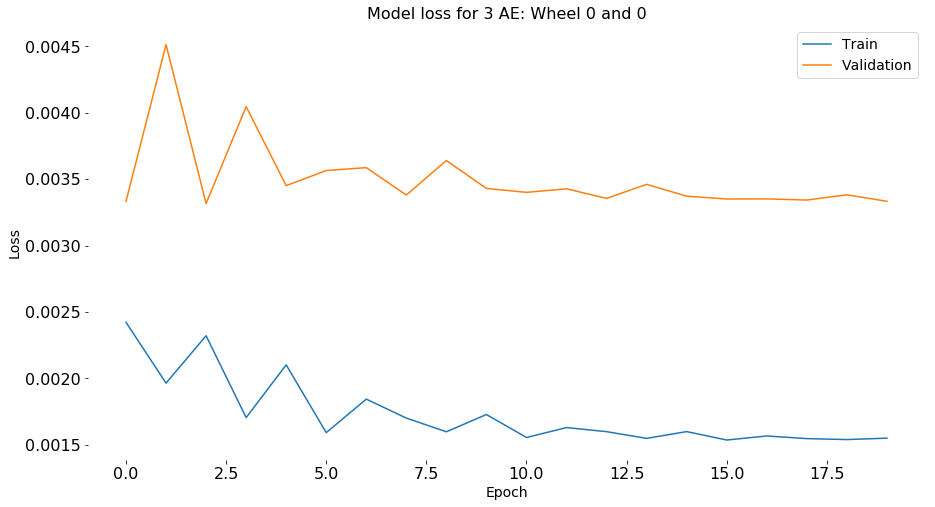

Training for wheel -1 and 1 with 2038 samples.


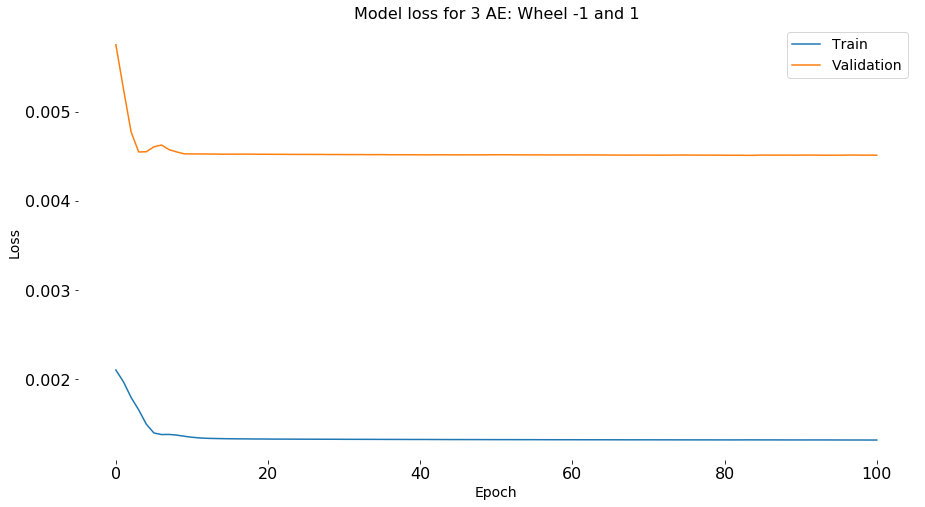

Training for wheel -2 and 2 with 2337 samples.


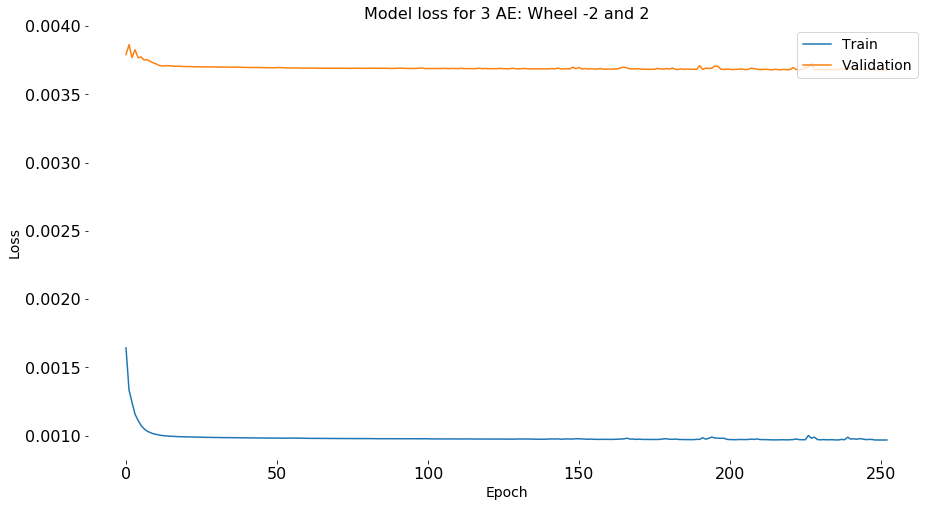

In [691]:
drift_tubes_chambers.loc[:, 'score_3_ae'] = np.nan
drift_tubes_chambers.loc[:, 'decoded_3_ae'] = np.nan
drift_tubes_chambers.loc[:, "encoded_3_ae_max"] = np.nan
drift_tubes_chambers.loc[:, "encoded_3_ae_ave"] = np.nan

for w in range(3):
    train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                                 (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                 (drift_tubes_chambers.station != 4) &
                                 (drift_tubes_chambers.score == 0)]

    test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                (drift_tubes_chambers.station != 4)]
    print("Training for wheel %s and %s with %s samples." %(-w, w, len(train)))
    x_train = np.array([])
    x_test = np.array([])

    for _, ch in train.iterrows(): 
        x_train = np.append(x_train, ch["content_powered_scaled"].reshape(12, 45, 1))

    for _, ch in test.iterrows(): 
        x_test = np.append(x_test, ch["content_powered_scaled"].reshape(12, 45, 1))

    x_train= np.reshape(x_train, (len(train), 12, 45, 1))
    x_test= np.reshape(x_test, (len(test), 12, 45, 1))

    autoencoder.compile(optimizer='adam', loss='mse')
    early_stopper = EarlyStopping(monitor="val_loss", patience=16, verbose=False, mode="auto")
    history = autoencoder.fit(x_train, x_train, epochs=2048, validation_split=0.2,
                              batch_size=512, shuffle=True, verbose=False, callbacks=[early_stopper])

    plot_loss(history.history, ("Model loss for 3 AE: Wheel %s and %s" % (-w, w)))

    decoded_imgs = autoencoder.predict(x_test).reshape(len(test), 12, 45)
    mse = np.sum(np.sum((x_test.reshape(len(test), 12, 45) - decoded_imgs) ** 2, axis = 1), axis=1)
    drift_tubes_chambers.loc[test.index, 'score_3_ae'] = mse

    drift_tubes_chambers.loc[test.index, 'decoded_3_ae'] = pd.DataFrame({"decoded_3_ae": decoded_imgs.tolist()},
                                                                           index=test.index)
    drift_tubes_chambers.loc[test.index, "encoded_3_ae_max"] = pd.DataFrame({"encoded_3_ae_max": encoder_max.predict(x_test).reshape(len(test),2).tolist()},
                                                                    index=test.index)
    drift_tubes_chambers.loc[train.index, "encoded_3_ae_max"] = pd.DataFrame({"encoded_3_ae_max": encoder_max.predict(x_train).reshape(len(train), 2).tolist()},
                                                                         index=train.index)
    drift_tubes_chambers.loc[test.index, "encoded_3_ae_ave"] = pd.DataFrame({"encoded_3_ae_ave": encoder_ave.predict(x_test).reshape(len(test),2).tolist()},
                                                                        index=test.index)
    drift_tubes_chambers.loc[train.index, "encoded_3_ae_ave"] = pd.DataFrame({"encoded_3_ae_ave": encoder_ave.predict(x_train).reshape(len(train), 2).tolist()},
                                                                         index=train.index)

Training for wheel 0 and 0 and station 1 with 440 samples.


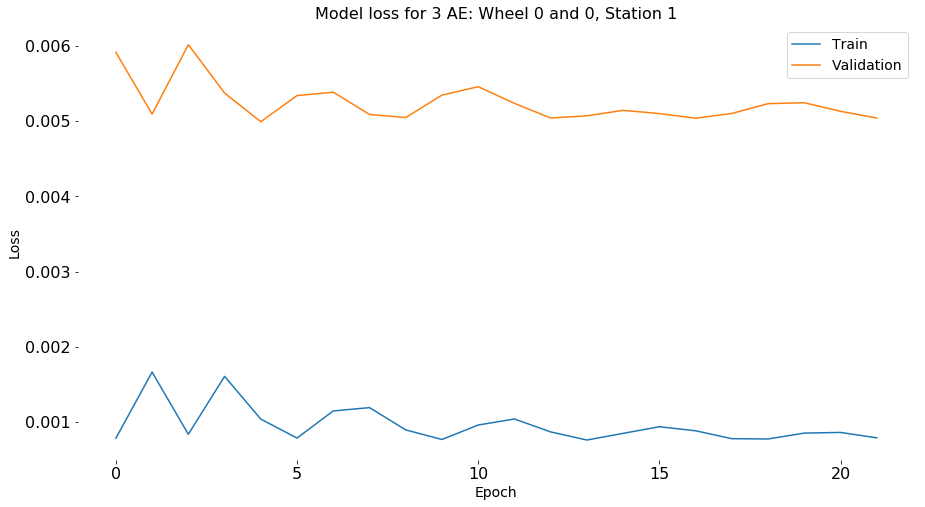

Training for wheel 0 and 0 and station 2 with 385 samples.


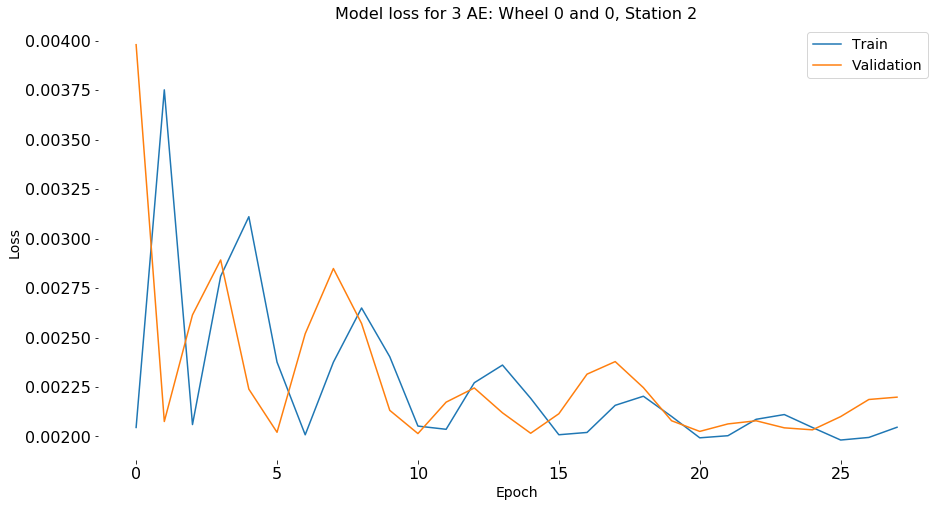

Training for wheel 0 and 0 and station 3 with 407 samples.


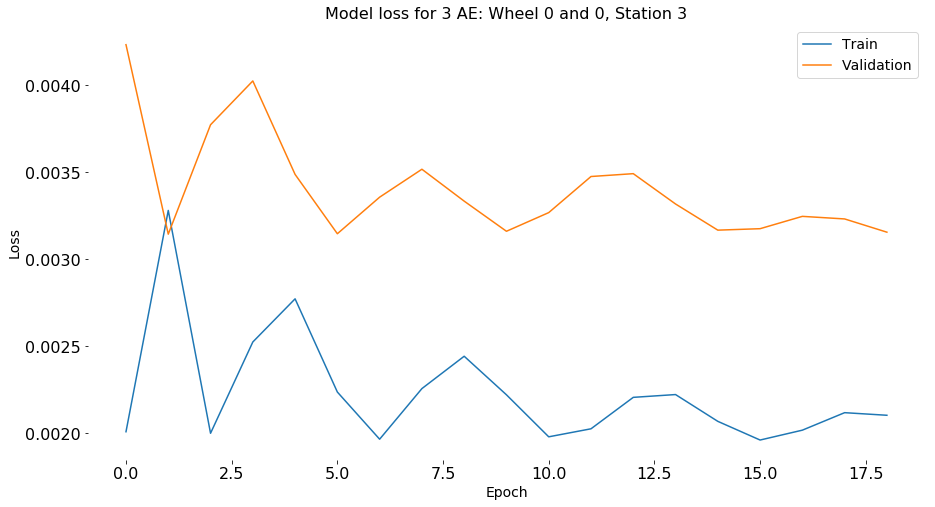

Training for wheel -1 and 1 and station 1 with 711 samples.


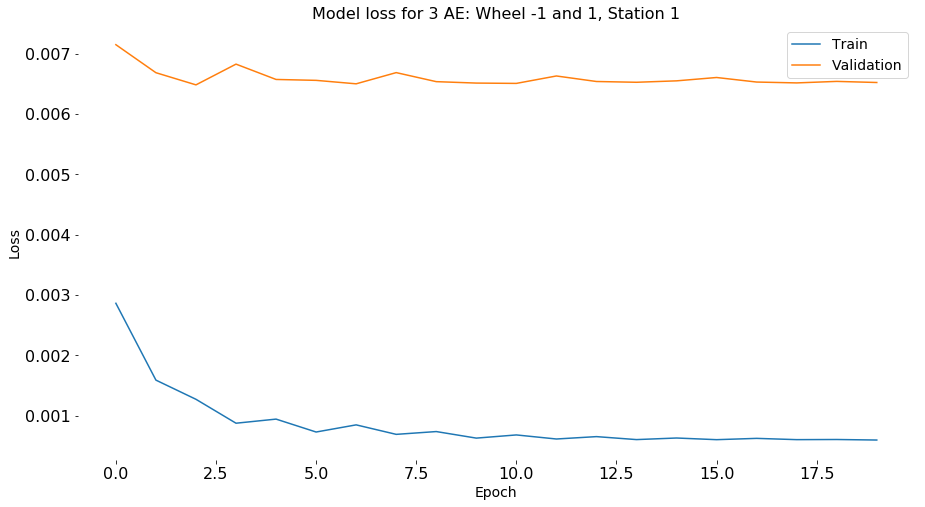

Training for wheel -1 and 1 and station 2 with 683 samples.


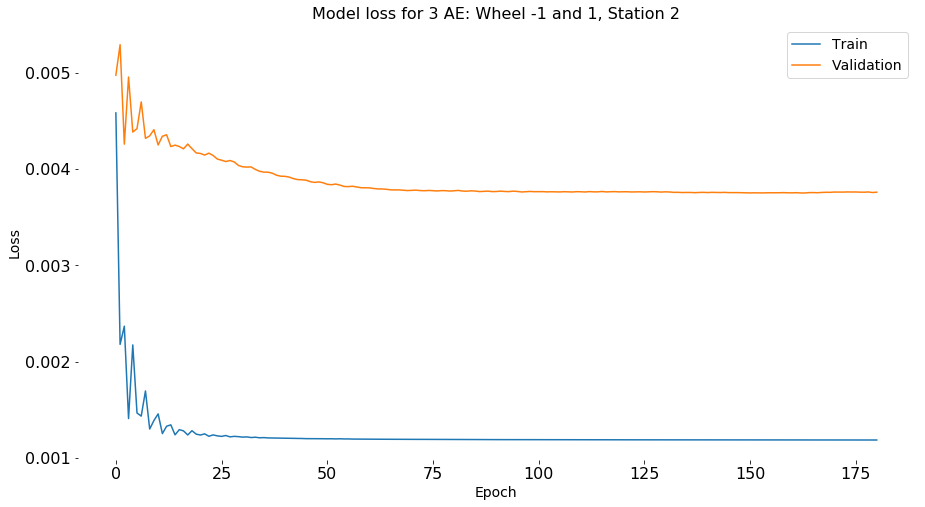

Training for wheel -1 and 1 and station 3 with 644 samples.


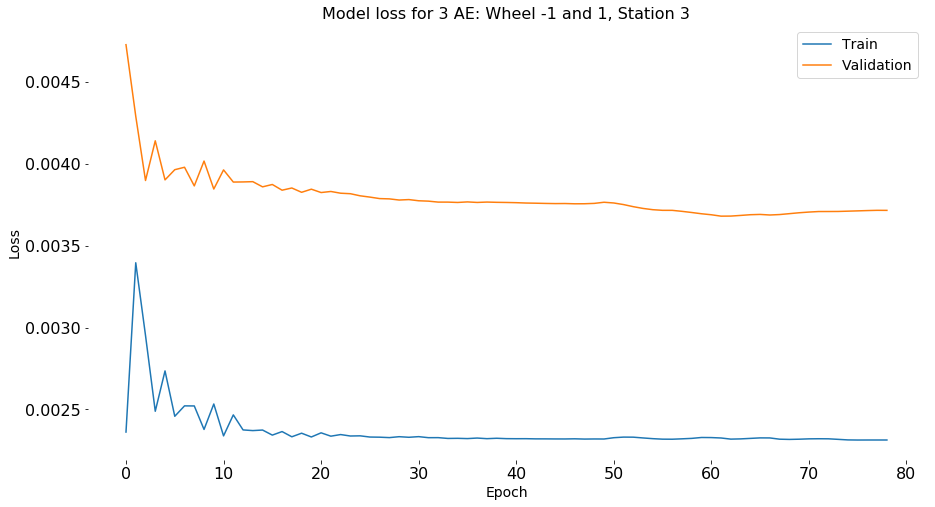

Training for wheel -2 and 2 and station 1 with 729 samples.


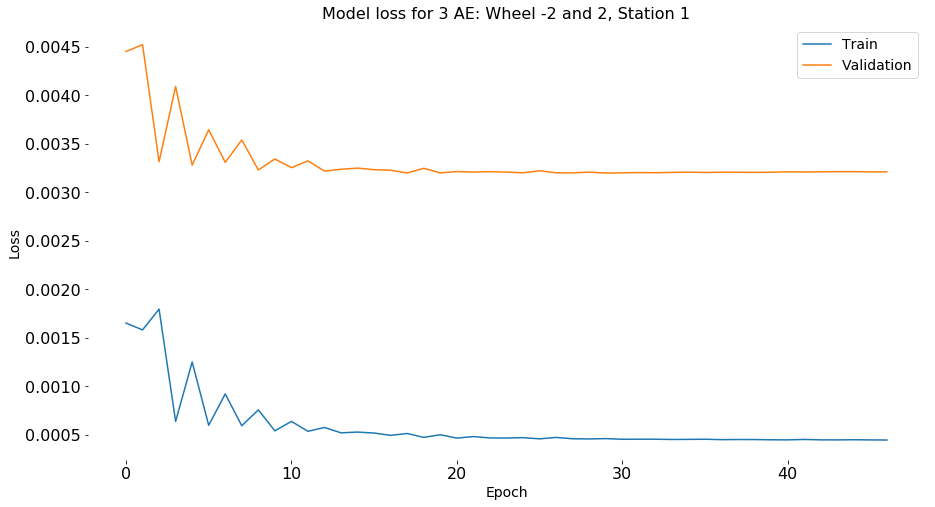

Training for wheel -2 and 2 and station 2 with 817 samples.


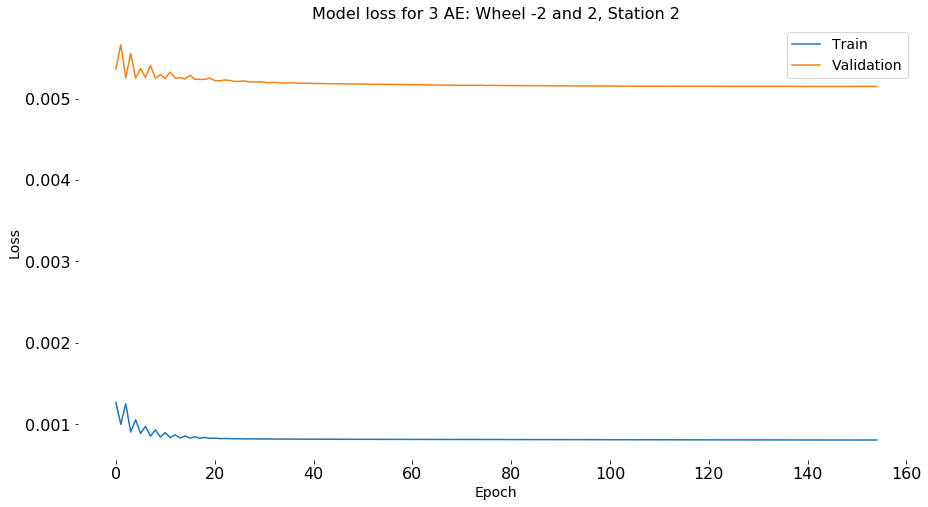

Training for wheel -2 and 2 and station 3 with 791 samples.


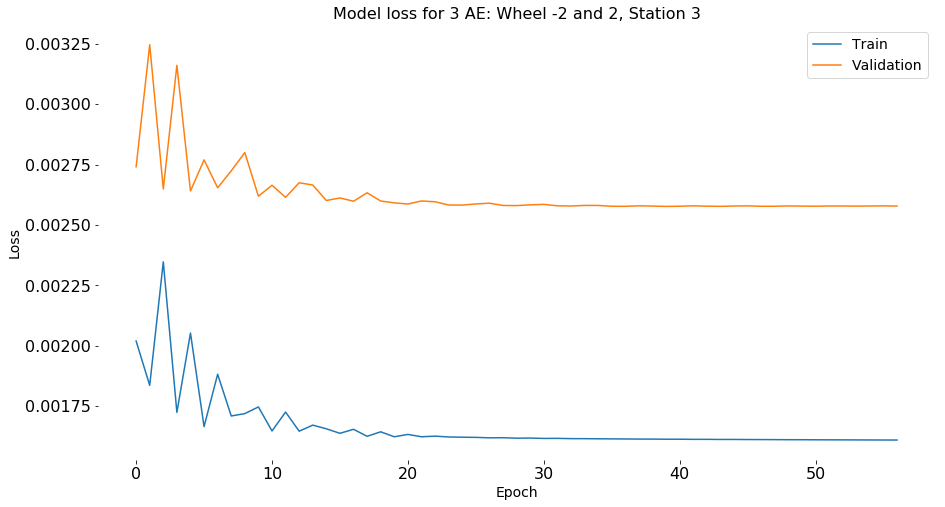

In [692]:
drift_tubes_chambers.loc[:, 'score_9_ae'] = np.nan
drift_tubes_chambers.loc[:, 'decoded_9_ae'] = np.nan
drift_tubes_chambers.loc[:, 'encoded_9_ae_ave'] = np.nan
drift_tubes_chambers.loc[:, 'encoded_9_ae_max'] = np.nan
for w in range(3):
    for st in range(1, 4):
        train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                                     (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                     (drift_tubes_chambers.station == st) &
                                     (drift_tubes_chambers.score == 0)]

        test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                    (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                    (drift_tubes_chambers.station == st)]

        print("Training for wheel %s and %s and station %s with %s samples." %(-w, w, st, len(train)))

        x_train = np.array([])
        x_test = np.array([])

        for _, ch in train.iterrows(): 
            x_train = np.append(x_train, ch["content_powered_scaled"].reshape(12, 45, 1))

        for _, ch in test.iterrows(): 
            x_test = np.append(x_test, ch["content_powered_scaled"].reshape(12, 45, 1))

        x_train= np.reshape(x_train, (len(train), 12, 45, 1))
        x_test= np.reshape(x_test, (len(test), 12, 45, 1))

        early_stopper = EarlyStopping(monitor="val_loss", patience=16, verbose=False, mode="auto")
        autoencoder.compile(optimizer='adam', loss='mse')
        history = autoencoder.fit(x_train, x_train, epochs=2048, validation_split=0.2,
                                  batch_size=512, shuffle=True, verbose=False, callbacks=[early_stopper])

        plot_loss(history.history, ("Model loss for 3 AE: Wheel %s and %s, Station %s" % (-w, w, st)))            
        decoded_imgs = autoencoder.predict(x_test).reshape(len(test), 12, 45)
        mse = np.sum(np.sum((x_test.reshape(len(test), 12, 45) - decoded_imgs) ** 2, axis = 1), axis=1)
        drift_tubes_chambers.loc[test.index, 'score_9_ae'] = mse

        drift_tubes_chambers.loc[test.index, 'decoded_9_ae'] = pd.DataFrame({"decoded_9_ae": decoded_imgs.tolist()},
                                                                       index=test.index)
        
        drift_tubes_chambers.loc[test.index, 'decoded_9_ae'] = pd.DataFrame({"decoded_9_ae": decoded_imgs.tolist()},
                                                                               index=test.index)
        drift_tubes_chambers.loc[test.index, "encoded_9_ae_max"] = pd.DataFrame({"encoded_9_ae_max": encoder_max.predict(x_test).reshape(len(test),2).tolist()},
                                                                        index=test.index)
        drift_tubes_chambers.loc[train.index, "encoded_9_ae_max"] = pd.DataFrame({"encoded_9_ae_max": encoder_max.predict(x_train).reshape(len(train), 2).tolist()},
                                                                             index=train.index)
        drift_tubes_chambers.loc[test.index, "encoded_9_ae_ave"] = pd.DataFrame({"encoded_9_ae_ave": encoder_ave.predict(x_test).reshape(len(test),2).tolist()},
                                                                            index=test.index)
        drift_tubes_chambers.loc[train.index, "encoded_9_ae_ave"] = pd.DataFrame({"encoded_9_ae_ave": encoder_ave.predict(x_train).reshape(len(train), 2).tolist()},
                                                                             index=train.index)

### Data snooping

Let's take a look at some of the results.

In [693]:
def original_vs_reconstructed(show):
    index = "(Run: %s, W: %s, St: %s, Sec: %s" % (show.run, show.wheel, show.station, show.sector)
    title = "Original Sample %s" % index
    plot_occupancy_hitmap(show.content_powered_scaled, title)
    title = "Reconstruction with 9 AE %s" % index
    plot_occupancy_hitmap(show.decoded_9_ae, title)
    title = "Reconstruction with 3 AE %s" % index
    plot_occupancy_hitmap(show.decoded_3_ae, title)
    title = "Reconstruction with 1 AE %s" % index
    plot_occupancy_hitmap(show.decoded_1_ae, title)

### Reconstruction of chamber with voltage fault:

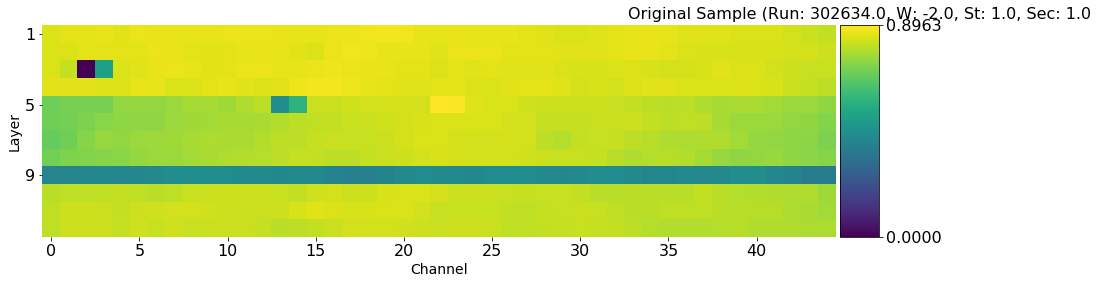

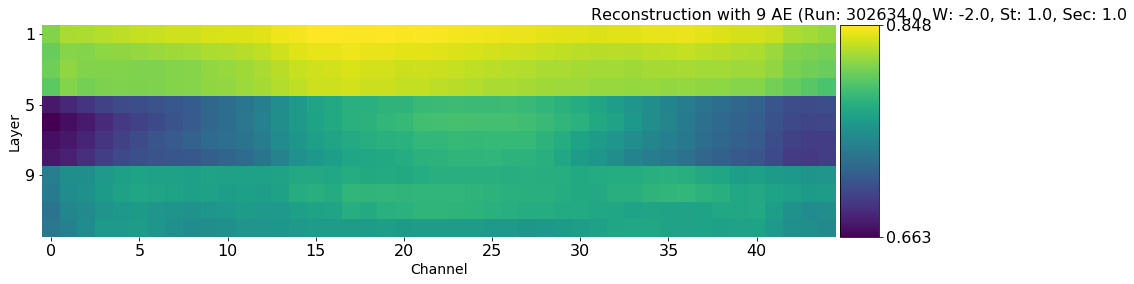

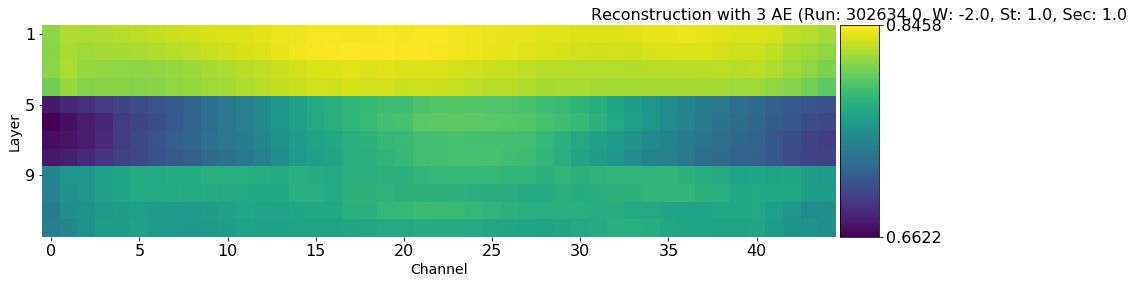

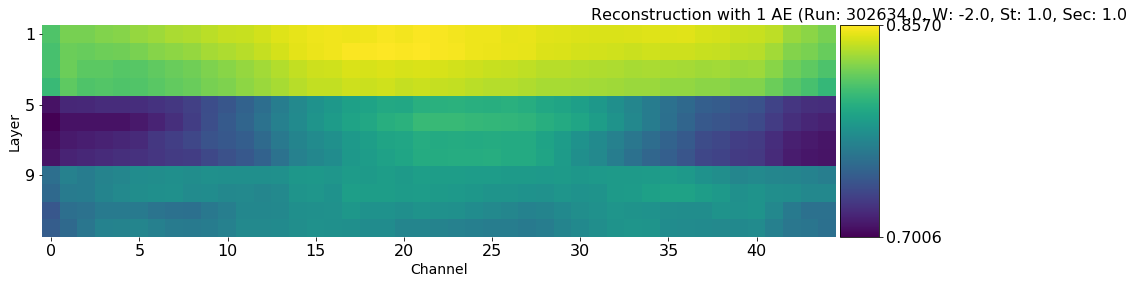

In [694]:
original_vs_reconstructed(drift_tubes_chambers[(drift_tubes_chambers["voltage_fault"] == 1) &
                                               (drift_tubes_chambers["station"] != 4)].iloc[0])

#### The best reconstruction for 1 ConvAE

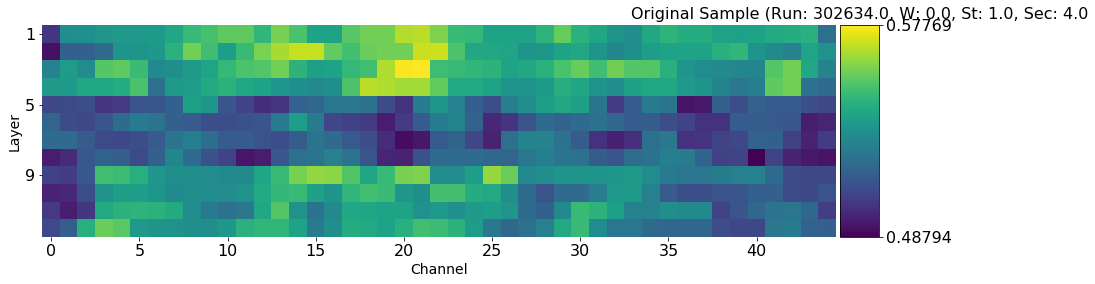

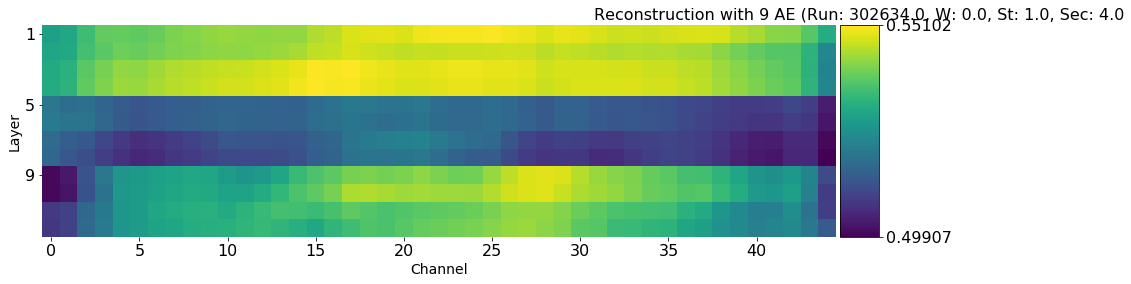

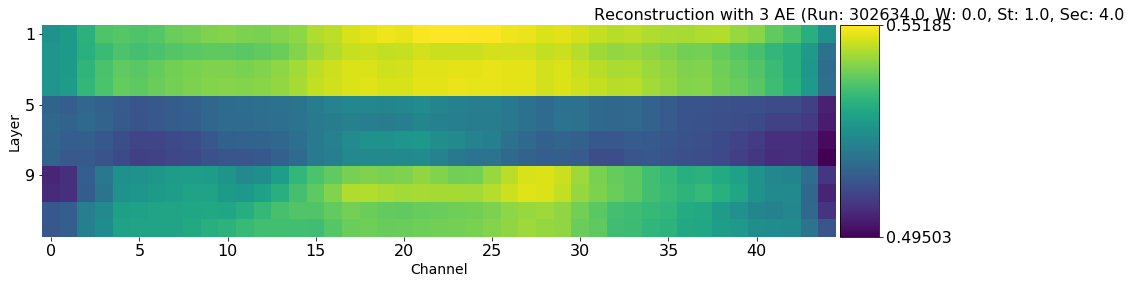

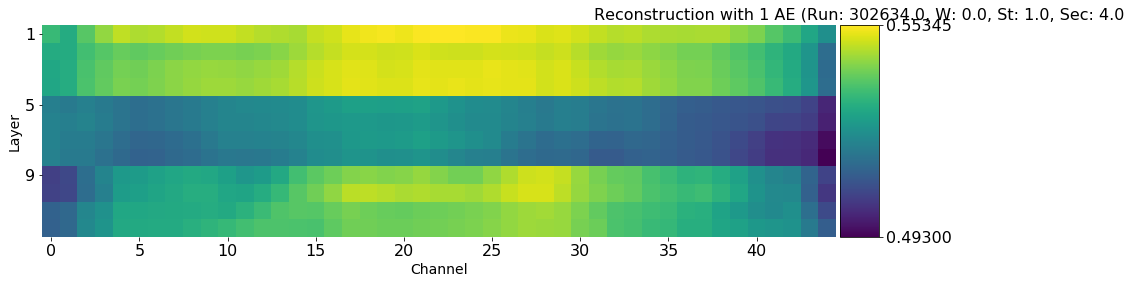

In [695]:
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_1_ae', ascending=1).iloc[0])

#### The worst reconstruction  for 1 ConvAE

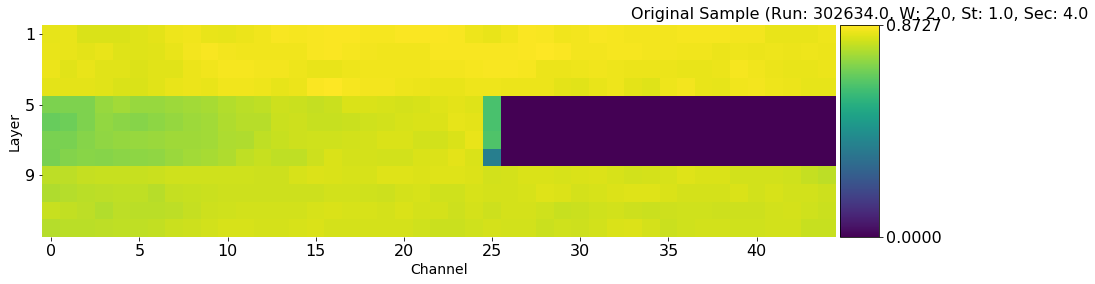

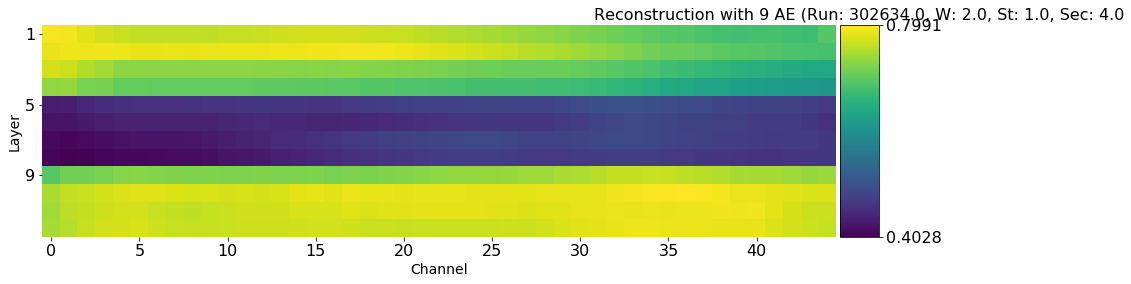

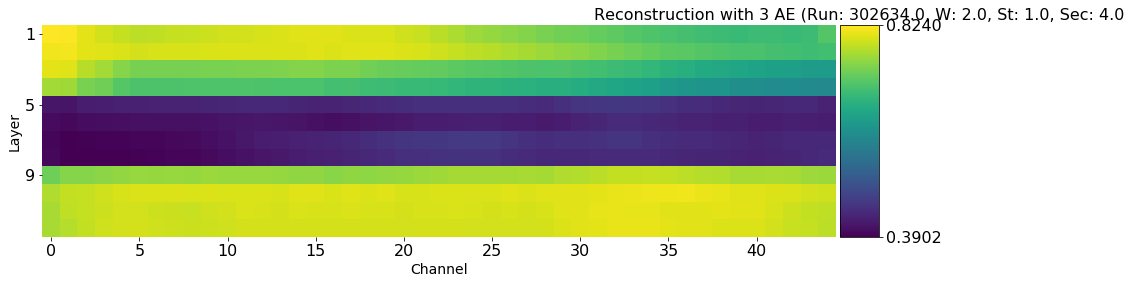

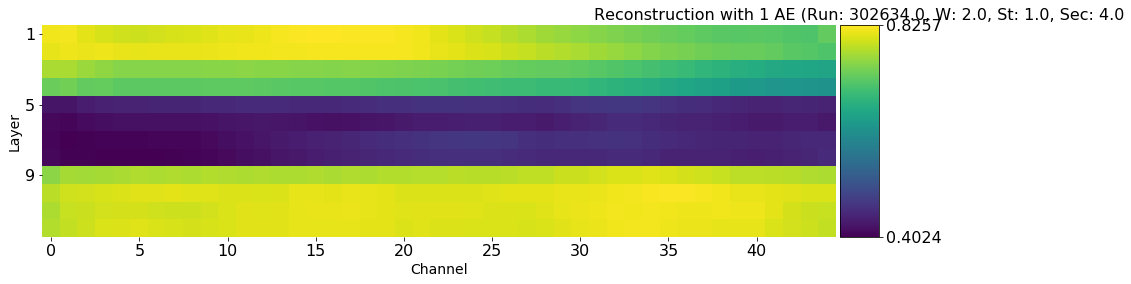

In [696]:
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_1_ae', ascending=0).iloc[0])

#### Best reconstruction for a chamber having at least one superlayer problem:

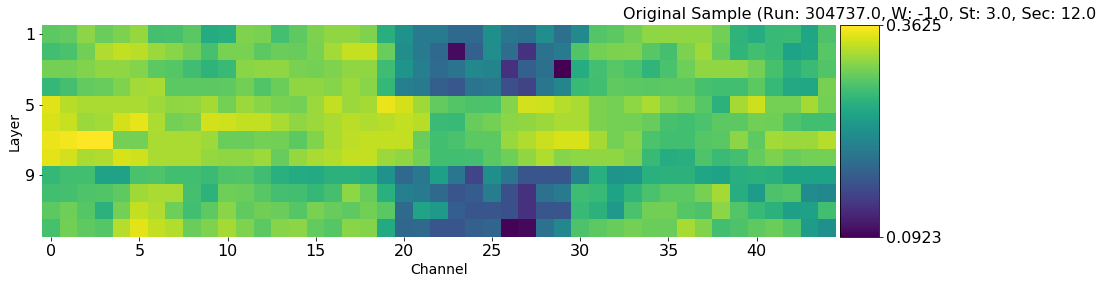

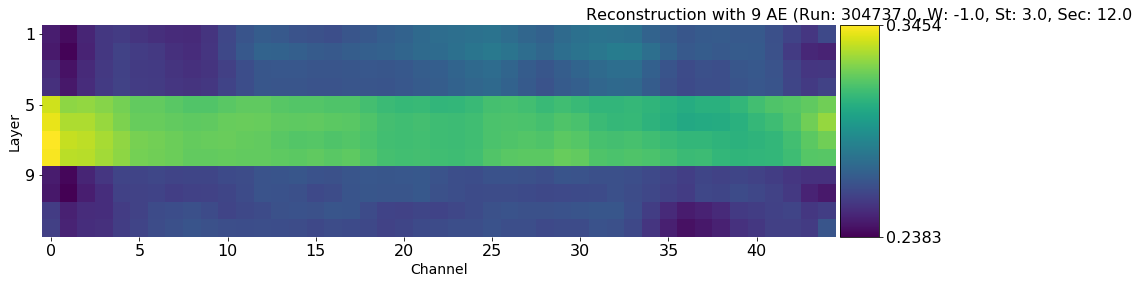

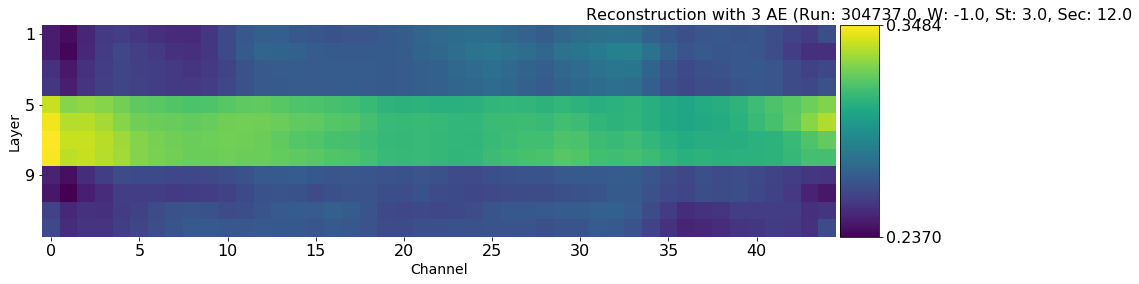

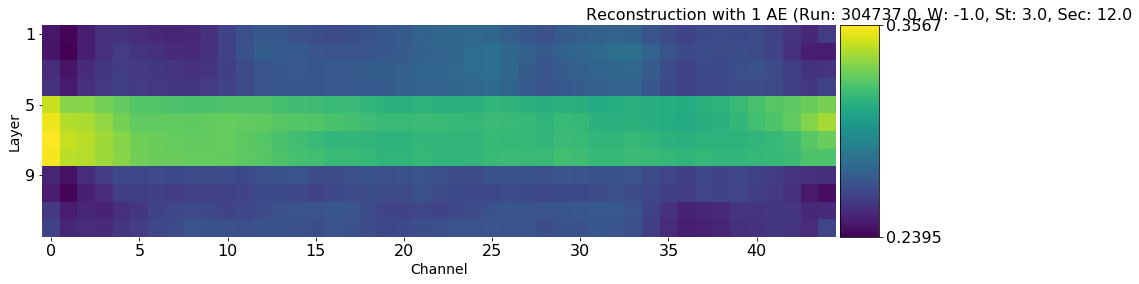

In [697]:
original_vs_reconstructed(drift_tubes_chambers[drift_tubes_chambers.score > 4].sort_values('score_1_ae', ascending=1).iloc[0])

#### The worst reconstruction for a chamber without problems wrt CNN: 

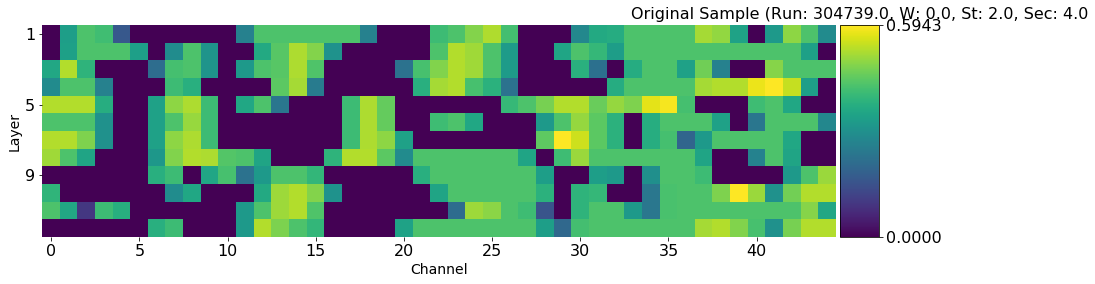

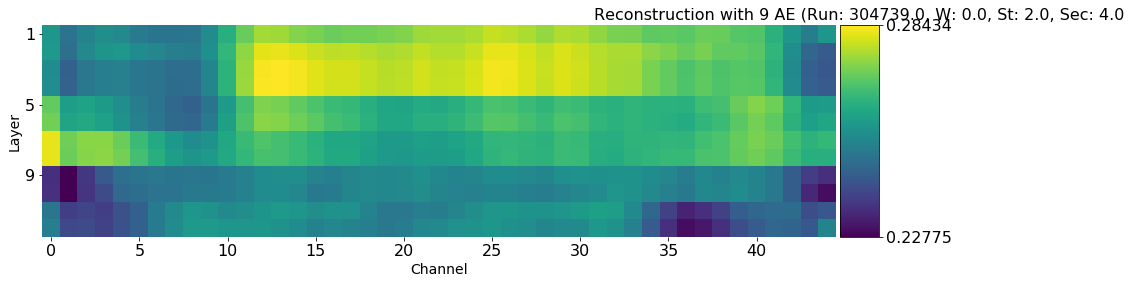

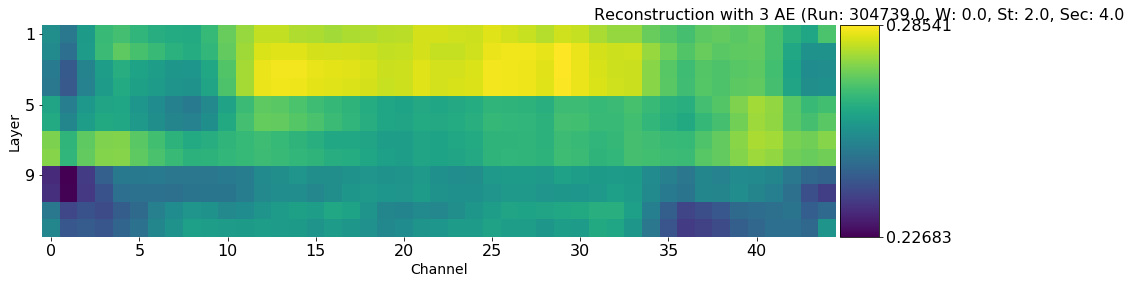

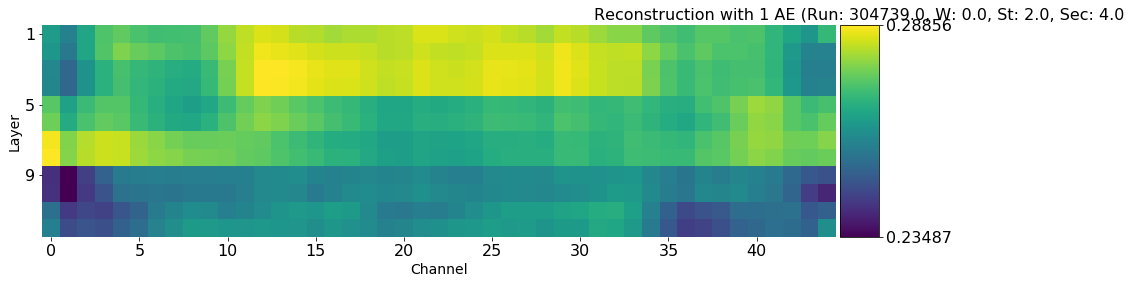

In [698]:
original_vs_reconstructed(drift_tubes_chambers[drift_tubes_chambers.score == 0].sort_values('score_1_ae', ascending=0).iloc[0])

## Evaluation

In this model we hoped to catch all the chambers that were considered problematic by CNN plus some others that the CNN classifier did see as good since the additional information about the numerical relations between chambers and layers was removed. Hence, in a ROC Curve we are not as interested as the AUC but the fall-out rate for sensitivity close to 1.

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


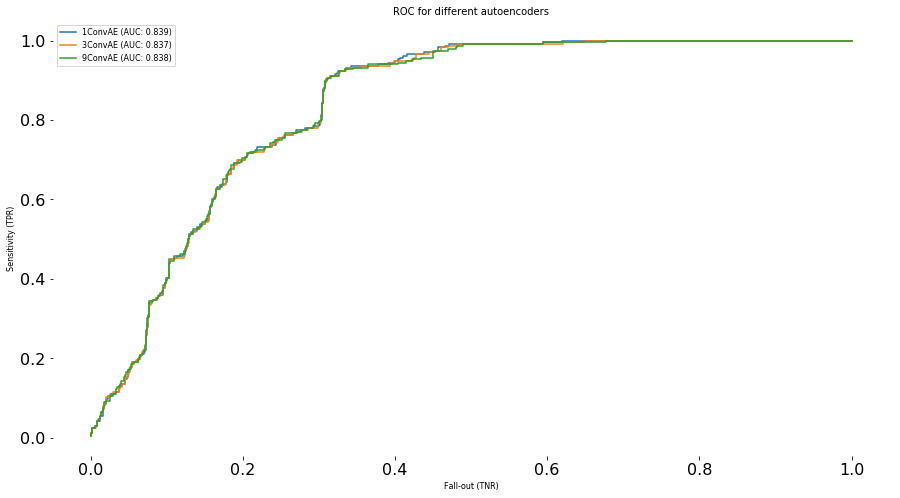

In [699]:
from sklearn.metrics import roc_curve, auc

evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                  (drift_tubes_chambers["station"] != 4)]
evaluation.score = (evaluation.score > 0) + 0

for ae in [1, 3, 9]:
    column = "score_%s_ae" % ae
    false_positive_rate, true_positive_rate, _ = roc_curve(evaluation["score"], evaluation[column])
    title = "%sConvAE (AUC: %s)" % (ae, round(auc(false_positive_rate, true_positive_rate), 3))
    plt.plot(false_positive_rate, true_positive_rate, label=title)

plt.title("ROC for different autoencoders", fontsize=10)
plt.ylabel("Sensitivity (TPR)", fontsize=8)
plt.xlabel("Fall-out (TNR)", fontsize=8)
plt.legend(fontsize=8)

plt.show();

Distribution of error for different autoencoders in the test set. Include all chambers that have less faulty layeres than FAULT.

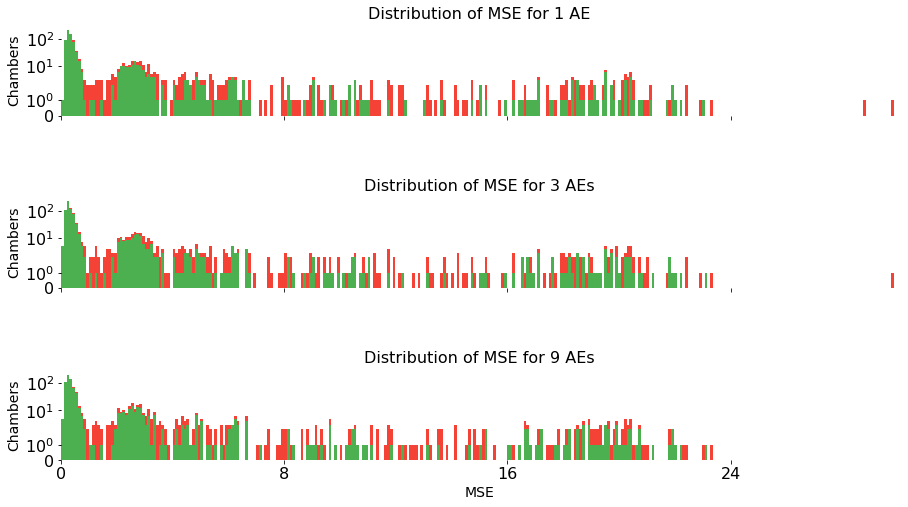

In [700]:
import matplotlib.ticker as mticker

FAULTS = 12

evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                  (drift_tubes_chambers["station"] != 4) &
                                  (drift_tubes_chambers["score"] <= FAULTS)]

binBoundaries = np.linspace(0, max(evaluation.score_1_ae.values), 300)

plt.figure()

ax1 = plt.subplot(3, 1, 1)
ax1.hist([evaluation[evaluation.score == 0].score_1_ae.values,
          evaluation[evaluation.score > 0].score_1_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax1.set_title("Distribution of MSE for 1 AE")
ax1.set_xlim([0,30])

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
ax2.hist([evaluation[evaluation.score == 0].score_3_ae.values, 
          evaluation[evaluation.score > 0].score_3_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax2.set_title("Distribution of MSE for 3 AEs")
ax2.set_xlim([0,30])

ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
ax3.hist([evaluation[evaluation.score == 0].score_9_ae.values,
          evaluation[evaluation.score > 0].score_9_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax3.set_title("Distribution of MSE for 9 AEs")
ax3.set_xlim([0,30])

ax3.xaxis.set_major_locator(mticker.MaxNLocator(4))
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.xlabel("MSE")
ax1.set_ylabel("Chambers")
ax2.set_ylabel("Chambers")
ax3.set_ylabel("Chambers")
plt.yscale("symlog")
plt.subplots_adjust(hspace=0.9)
plt.show()

### Dimensionality reduction

Dimensionality reduction with ConvAE:

In [701]:
def dimentionality_reduction(color_by, encoder):
    for ae in [1, 3, 9]:
        column = "encoded_%s_ae_%s" % (ae, encoder)
        evaluation = drift_tubes_chambers[drift_tubes_chambers[column].notnull()] # filter here
        encoded = np.array([_ for _ in evaluation[column].values])
        plt.scatter(encoded[:, 0], encoded[:, 1], c=[_ for _ in evaluation[color_by].values],
                    alpha=0.3, s=20, marker='s')
        if color_by == "station":
            tick = range(1, 4)
        else:
            tick = range(-2, 3)
        cbar = plt.colorbar(ticks=tick)
        cbar.ax.set_yticklabels([str(_) for _ in tick])
        plt.title(("For %s AE" % ae), fontsize = 8)
        plt.show()

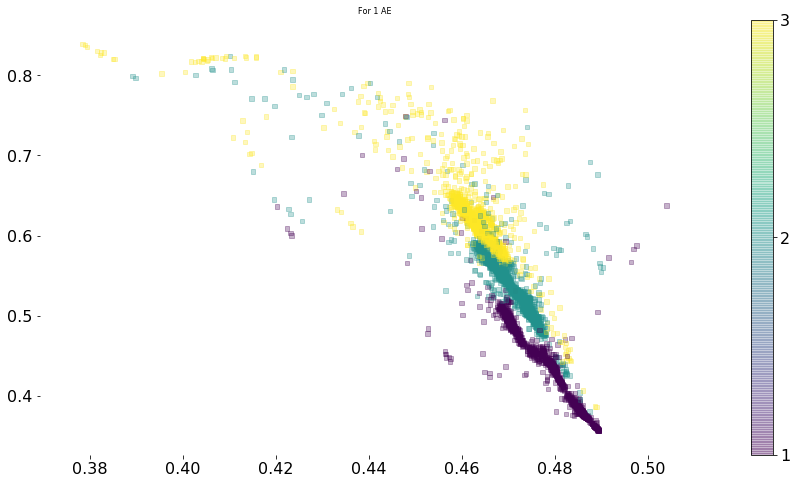

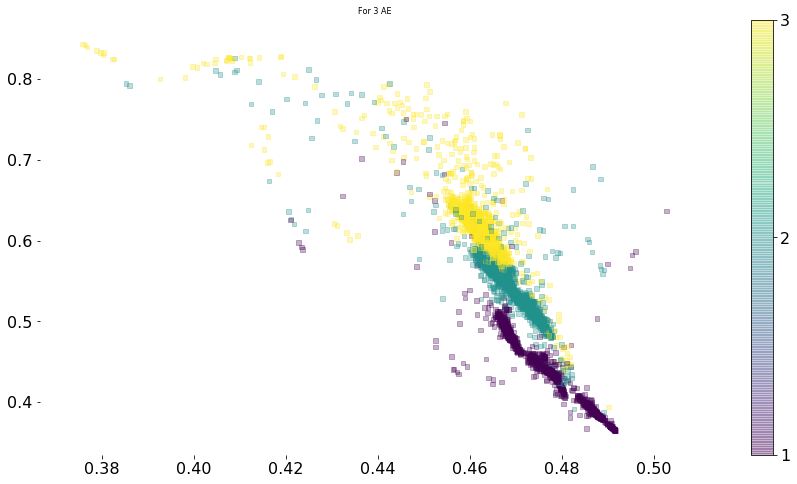

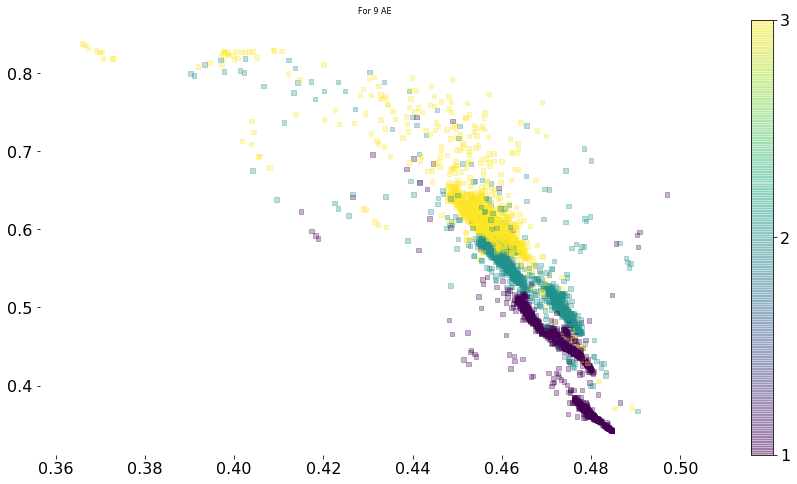

In [702]:
dimentionality_reduction("station", "max")

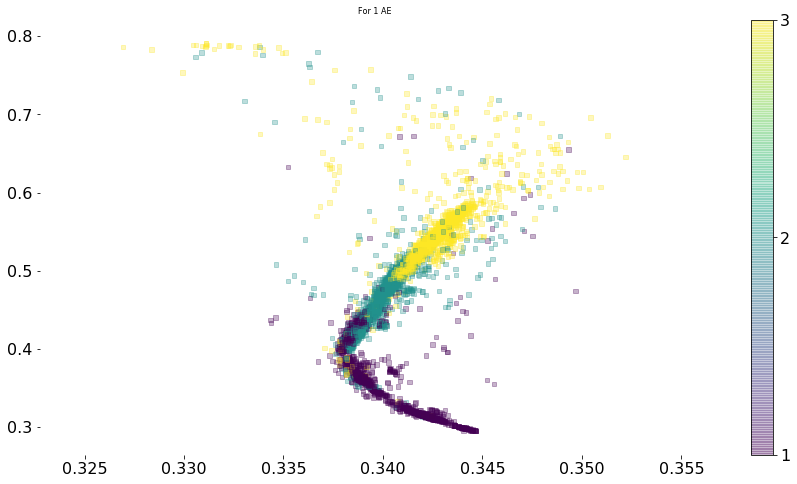

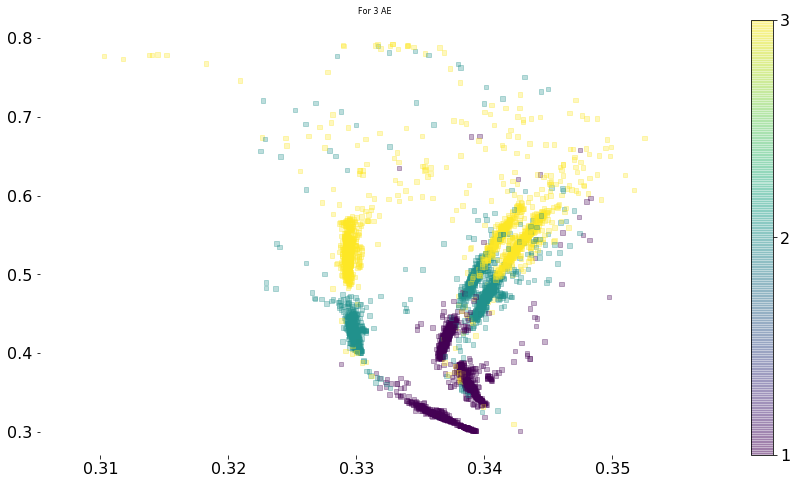

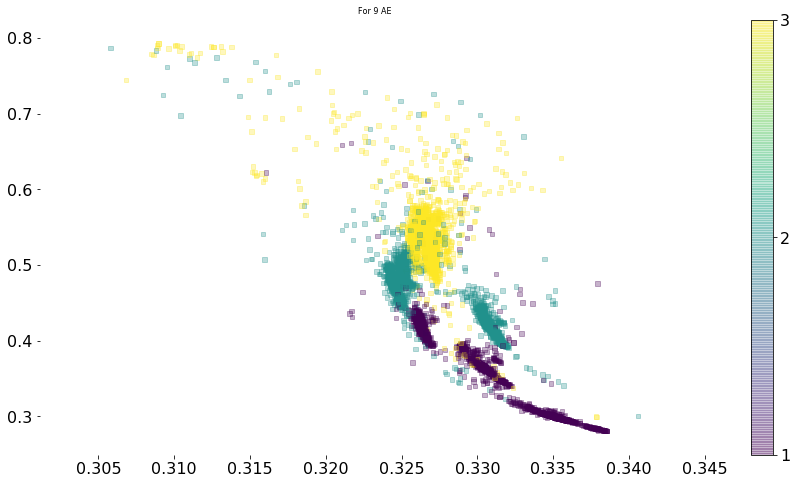

In [703]:
dimentionality_reduction("station", "ave")

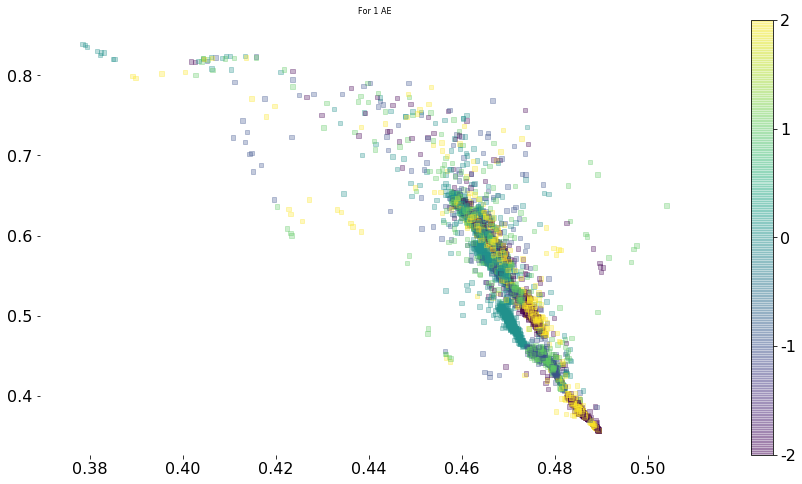

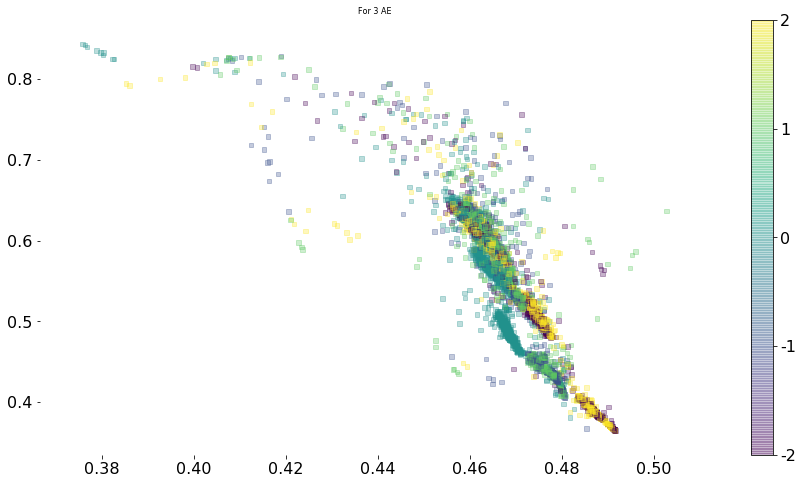

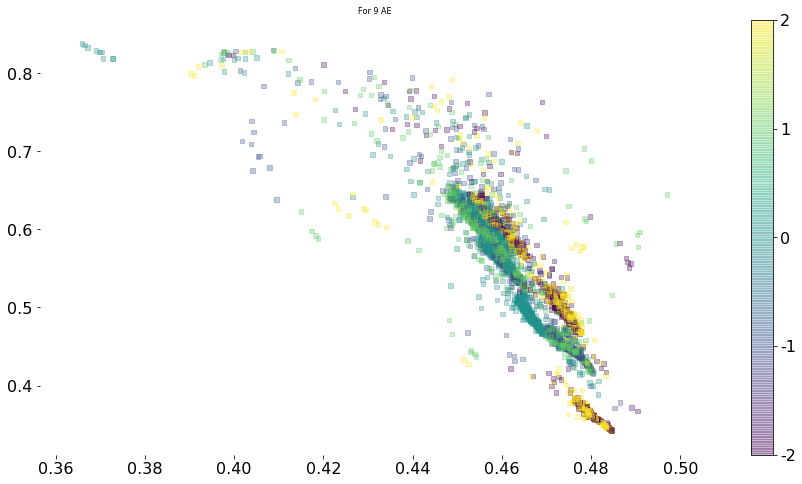

In [704]:
dimentionality_reduction("wheel", "max")

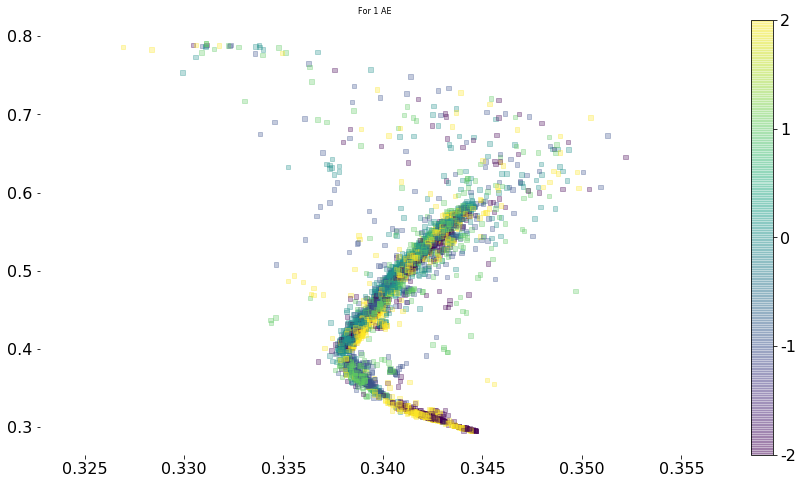

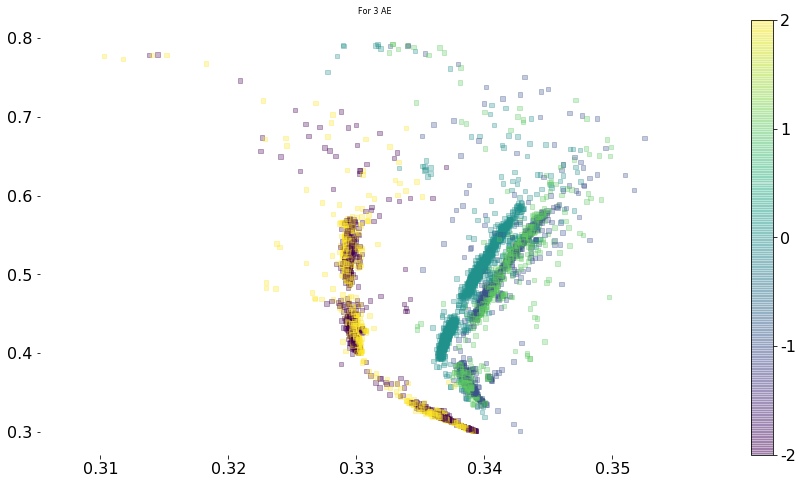

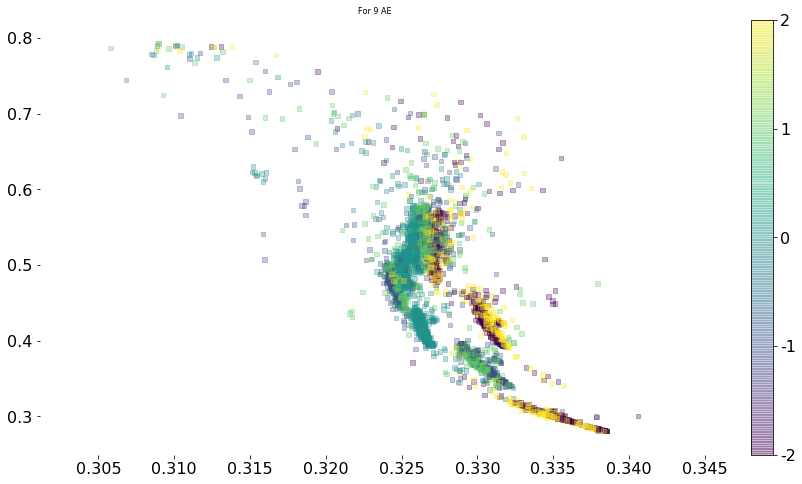

In [705]:
dimentionality_reduction("wheel", "ave")

### Filip's Test

In [706]:
# do it with median/average and dimentinality_rediction
def filip(chamber):
    return np.array([[np.median(chamber), np.mean(chamber)]])

drift_tubes_chambers["filip"] = drift_tubes_chambers["content_powered_scaled"].apply(filip)

def dimentionality_reduction_filip(color_by, encoder):
    column = "filip"
    evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"] == 284041)
                                      & (drift_tubes_chambers["station"] != 4)] # filter here
    encoded = np.concatenate(evaluation[column].values)
    plt.scatter(encoded[:, 0], encoded[:, 1], c=[_ for _ in evaluation[color_by].values],
                alpha=0.3, s=20, marker='s')
    if color_by == "station":
        tick = range(1, 4)
    else:
        tick = range(-2, 3)
    cbar = plt.colorbar(ticks=tick)
    cbar.ax.set_yticklabels([str(_) for _ in tick])
    plt.title(("For %s AE" % ae), fontsize = 8)
    plt.show()

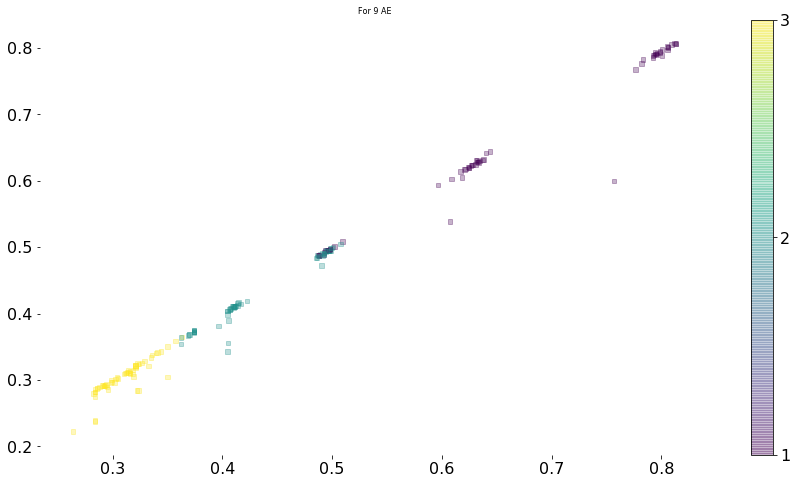

In [707]:
dimentionality_reduction_filip("station", None)

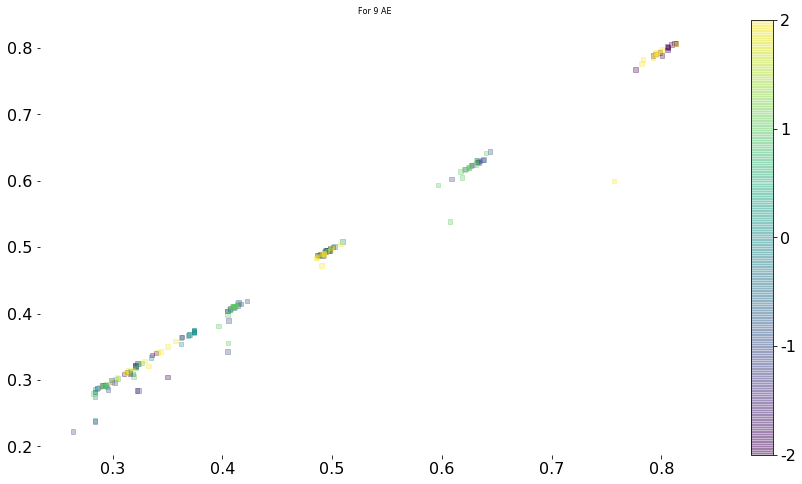

In [708]:
dimentionality_reduction_filip("wheel", None)

## Spotting the Voltage Fault

### Proximity to latent layer

In [709]:
for w in range(0, 3):
    for st in range(1, 4):
        train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                                     (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                     (drift_tubes_chambers.station == st) &
                                     (drift_tubes_chambers.score == 0)]

        test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                    (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                    (drift_tubes_chambers.station == st)]

        centroid_filip = np.array([np.mean(np.concatenate(train["filip"].values)[:, 0]),
                                   np.mean(np.concatenate(train["filip"].values)[:, 1])])
        
        foo = []
        for sample in np.concatenate(test["filip"].values):
            foo.append(np.linalg.norm(sample - centroid_filip))
        drift_tubes_chambers.loc[test.index, "distance_filip"] = pd.DataFrame({"distance_filip": foo}, index=test.index)
        
        for ae in [1, 3, 9]:
            for encoder in ['ave', 'max']:
                column = "encoded_%s_ae_%s" % (ae, encoder)
                new_column = "distance_%s" % column
                
                centroid_ae = np.mean(np.concatenate(train[column].values).reshape(-1, 2), axis=0)
                
                foo = []
                for sample in np.concatenate(test[column].values).reshape(-1, 2):
                    foo.append(np.linalg.norm(sample - centroid_ae))
                drift_tubes_chambers.loc[test.index, new_column] = pd.DataFrame({("%s" % new_column): foo}, index=test.index)

In [710]:
def get_roc_curve(test_df, models, runs):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    test_df = test_df[(test_df["run"].isin(runs)) & (test_df["run"] != 304739) &
                      (test_df["station"] != 4) &
                      (test_df["score"] == 0)]

    for legend_label, model_score, color in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["combined_score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, color, linewidth=1.5,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))

    plt.title("ROC", loc='right')
    plt.legend(loc='best')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    plt.show();

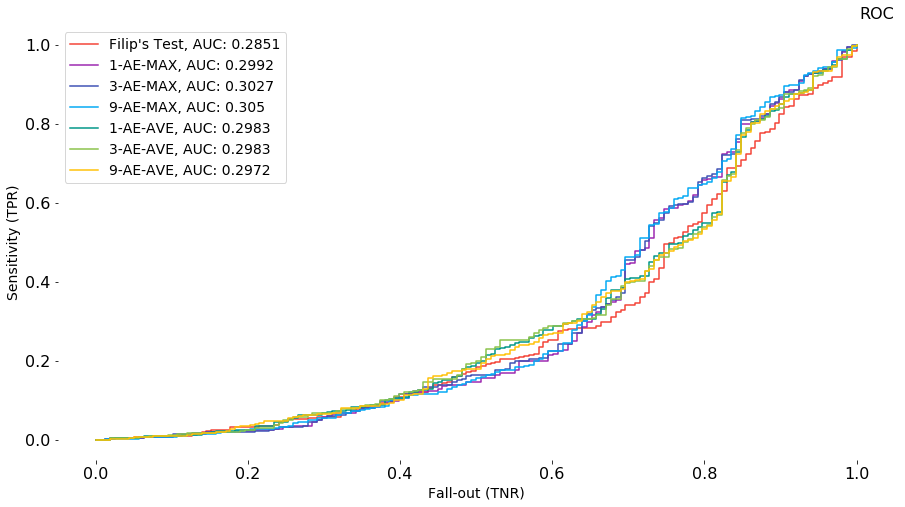

In [711]:
get_roc_curve(drift_tubes_chambers, 
              [("Filip's Test", "distance_filip", color_palette[0]),
                ("1-AE-MAX", "distance_encoded_1_ae_max", color_palette[1]),
                ("3-AE-MAX", "distance_encoded_3_ae_max", color_palette[2]),
                ("9-AE-MAX", "distance_encoded_9_ae_max", color_palette[3]),
                ("1-AE-AVE", "distance_encoded_1_ae_ave", color_palette[4]),
                ("3-AE-AVE", "distance_encoded_3_ae_ave", color_palette[5]),
                ("9-AE-AVE", "distance_encoded_9_ae_ave", color_palette[6])],
             test_run)

### Changing the metric

Error contribution per layer:

In [712]:
def error_per_layer(run):
    samples = drift_tubes_chambers[(drift_tubes_chambers["run"] == run) &
                                   (drift_tubes_chambers["score"] == 0) &
                                   (drift_tubes_chambers["station"] != 4)]

    reconstruction = (np.concatenate(samples["content_powered_scaled"].values).reshape(-1, 12, 45) -
                      np.concatenate(samples["decoded_1_ae"].values).reshape(-1, 12, 45))
    
    foo = np.array([])
    for _ in reconstruction:
        foo = np.append(foo, np.sum(abs(_), axis=1))
        
    return np.mean(foo.reshape(-1, 12), axis=0)

In [713]:
for run in test_run:
    errors = error_per_layer(run)
    errors = errors / sum(errors)
    s = [str(round(e, 2)) for e in errors]
    print("%s: %s" %(run, s))

302634: ['0.03', '0.03', '0.03', '0.03', '0.04', '0.04', '0.04', '0.04', '0.44', '0.09', '0.09', '0.09']
302635: ['0.08', '0.09', '0.08', '0.09', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08']
304737: ['0.07', '0.07', '0.07', '0.07', '0.08', '0.08', '0.08', '0.08', '0.17', '0.07', '0.07', '0.08']
304738: ['0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.08', '0.15', '0.08', '0.08', '0.08']
304739: ['0.08', '0.08', '0.08', '0.08', '0.09', '0.09', '0.09', '0.09', '0.09', '0.08', '0.08', '0.08']
304740: ['0.07', '0.08', '0.07', '0.07', '0.08', '0.08', '0.07', '0.07', '0.19', '0.07', '0.07', '0.07']


In [714]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_1_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = sample / sum(sample)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_1_ae_percent"] = pd.DataFrame({"score_1_ae_percent": foo}, index=test.index)

In [715]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_3_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = sample / sum(sample)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_3_ae_percent"] = pd.DataFrame({"score_3_ae_percent": foo}, index=test.index)

In [716]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_9_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = sample / sum(sample)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_9_ae_percent"] = pd.DataFrame({"score_9_ae_percent": foo}, index=test.index)

In [717]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_1_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_1_ae_abs"] = pd.DataFrame({"score_1_ae_abs": foo}, index=test.index)

In [718]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_3_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_3_ae_abs"] = pd.DataFrame({"score_3_ae_abs": foo}, index=test.index)

In [719]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_9_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_9_ae_abs"] = pd.DataFrame({"score_9_ae_abs": foo}, index=test.index)

In [720]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_1_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = [np.sum(sample[0:4]), np.sum(sample[4:8]), np.sum(sample[8:12])]
    sample = sample / sum(sample)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_1_ae_percent_sl"] = pd.DataFrame({"score_1_ae_percent_sl": foo}, index=test.index)

In [721]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_3_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = [np.sum(sample[0:4]), np.sum(sample[4:8]), np.sum(sample[8:12])]
    sample = sample / sum(sample)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_3_ae_percent_sl"] = pd.DataFrame({"score_3_ae_percent_sl": foo}, index=test.index)

In [722]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_9_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = [np.sum(sample[0:4]), np.sum(sample[4:8]), np.sum(sample[8:12])]
    sample = sample / sum(sample)
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_9_ae_percent_sl"] = pd.DataFrame({"score_9_ae_percent_sl": foo}, index=test.index)

In [723]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_1_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = [np.sum(sample[0:4]), np.sum(sample[4:8]), np.sum(sample[8:12])]
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_1_ae_abs_sl"] = pd.DataFrame({"score_1_ae_abs_sl": foo}, index=test.index)

In [724]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_3_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = [np.sum(sample[0:4]), np.sum(sample[4:8]), np.sum(sample[8:12])]
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_3_ae_abs_sl"] = pd.DataFrame({"score_3_ae_abs_sl": foo}, index=test.index)

In [725]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = []
for sample in test["content_powered_scaled"] - test["decoded_9_ae"]:
    sample = abs(sample)
    sample = np.sum(sample, axis=1)
    sample = [np.sum(sample[0:4]), np.sum(sample[4:8]), np.sum(sample[8:12])]
    foo.append(np.max(sample))

drift_tubes_chambers.loc[test.index, "score_9_ae_abs_sl"] = pd.DataFrame({"score_9_ae_abs_sl": foo}, index=test.index)

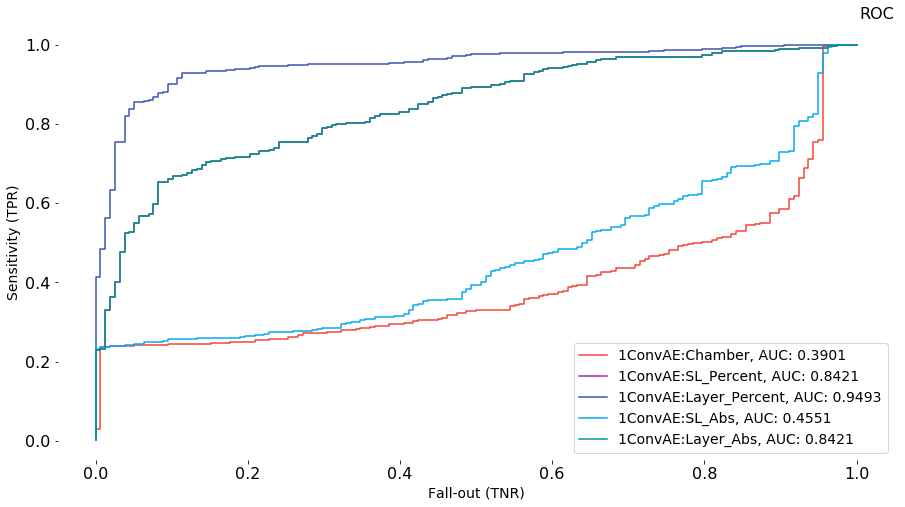

In [726]:
get_roc_curve(drift_tubes_chambers, 
              [("1ConvAE:Chamber", "score_1_ae", color_palette[0]),
               ("1ConvAE:SL_Percent", "score_1_ae_percent_sl", color_palette[1]),
               ("1ConvAE:Layer_Percent", "score_1_ae_percent", color_palette[2]),
               ("1ConvAE:SL_Abs", "score_1_ae_abs_sl", color_palette[3]),
               ("1ConvAE:Layer_Abs", "score_1_ae_percent_sl", color_palette[4])],
             test_run)

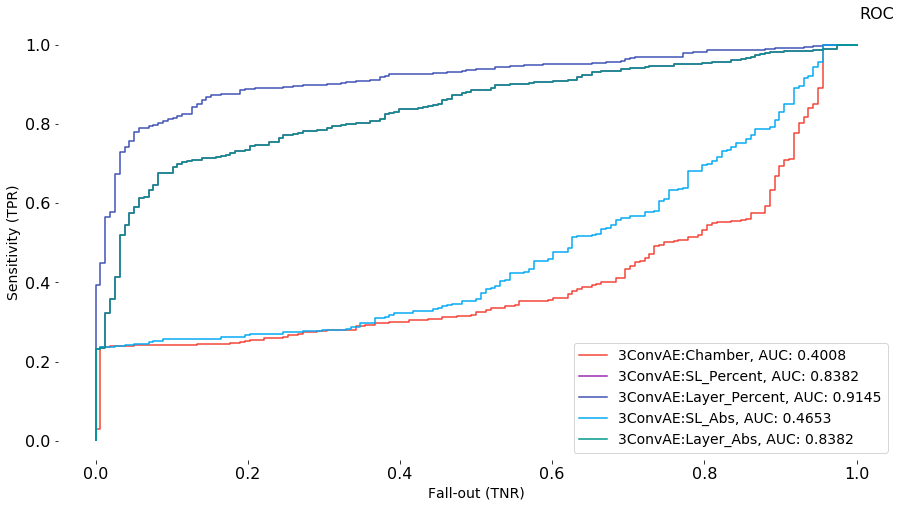

In [727]:
get_roc_curve(drift_tubes_chambers, 
              [("3ConvAE:Chamber", "score_3_ae", color_palette[0]),
               ("3ConvAE:SL_Percent", "score_3_ae_percent_sl", color_palette[1]),
               ("3ConvAE:Layer_Percent", "score_3_ae_percent", color_palette[2]),
               ("3ConvAE:SL_Abs", "score_3_ae_abs_sl", color_palette[3]),
               ("3ConvAE:Layer_Abs", "score_3_ae_percent_sl", color_palette[4])],
             test_run)

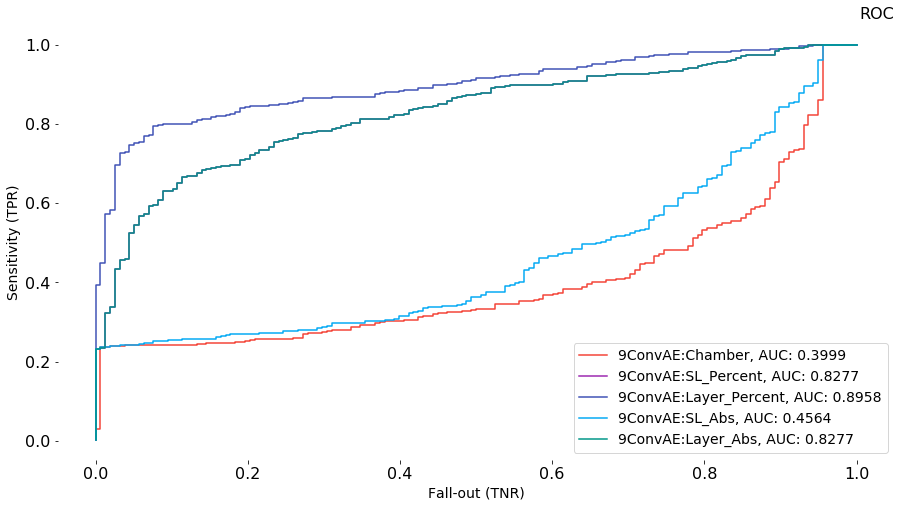

In [728]:
get_roc_curve(drift_tubes_chambers, 
              [("9ConvAE:Chamber", "score_9_ae", color_palette[0]),
               ("9ConvAE:SL_Percent", "score_9_ae_percent_sl", color_palette[1]),
               ("9ConvAE:Layer_Percent", "score_9_ae_percent", color_palette[2]),
               ("9ConvAE:SL_Abs", "score_9_ae_abs_sl", color_palette[3]),
               ("9ConvAE:Layer_Abs", "score_9_ae_percent_sl", color_palette[4])],
             test_run)

In [729]:
def error_distribution(score, bins):
    evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                      (drift_tubes_chambers["run"] != 304739) &
                                      (drift_tubes_chambers["station"] != 4)]
    binBoundaries = np.linspace(0, max(evaluation[score].values), bins)

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.hist([evaluation[(evaluation.combined_score == -1)][score].values, # Those good
              evaluation[(evaluation.voltage_fault == 1) & (evaluation.score == 0) & (evaluation.run == 302634)][score].values, # Voltage < 0.7
              evaluation[(evaluation.voltage_fault == 1) & (evaluation.score == 0) & (evaluation.run != 302634)][score].values, # Voltage > 0.7          
              evaluation[(evaluation.voltage_fault == -1) & (evaluation.score > 0)][score].values, # CNN Problem
              evaluation[(evaluation.voltage_fault == 1) & (evaluation.score > 0)][score].values], # CNN & Voltage Problem
             bins=binBoundaries, stacked=True, color=["#4CAF50", "#B71C1C", "#E57373", "#B0BEC5", "#90A4AE"],
            label=("All good", "Layer 9 almost off", "Layer 9 underperforming",
                   "CNN fault detected", "CNN fault detected plus voltage problem"))

    ax1.set_title("Distribution of MSE")
    ax1.set_ylabel("Chambers")
    #ax1.set_xlim([0, 15])
    plt.legend()
    plt.xlabel("MSE")
    plt.yscale("symlog")
    plt.subplots_adjust(hspace=0.9)
    plt.show()

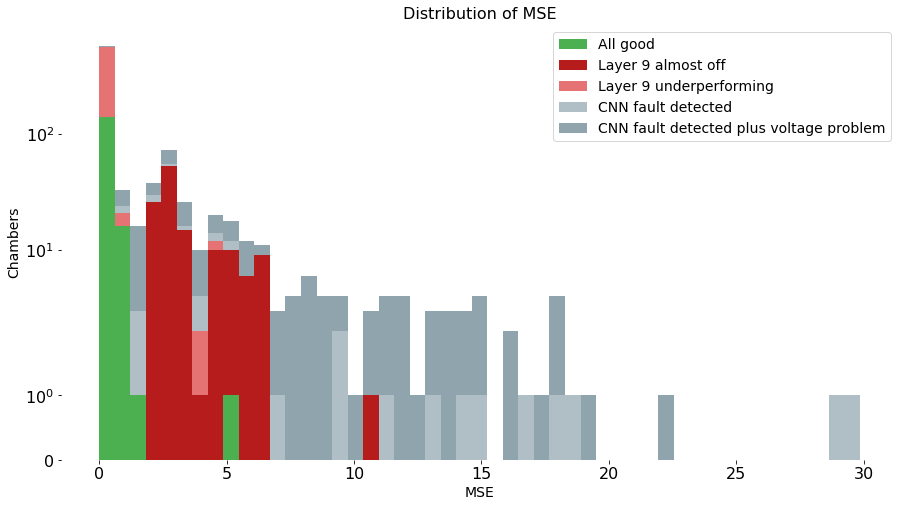

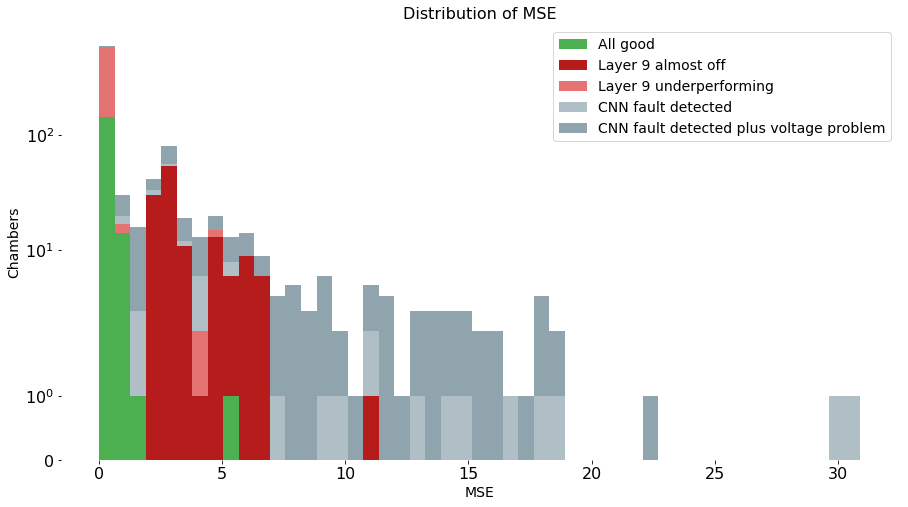

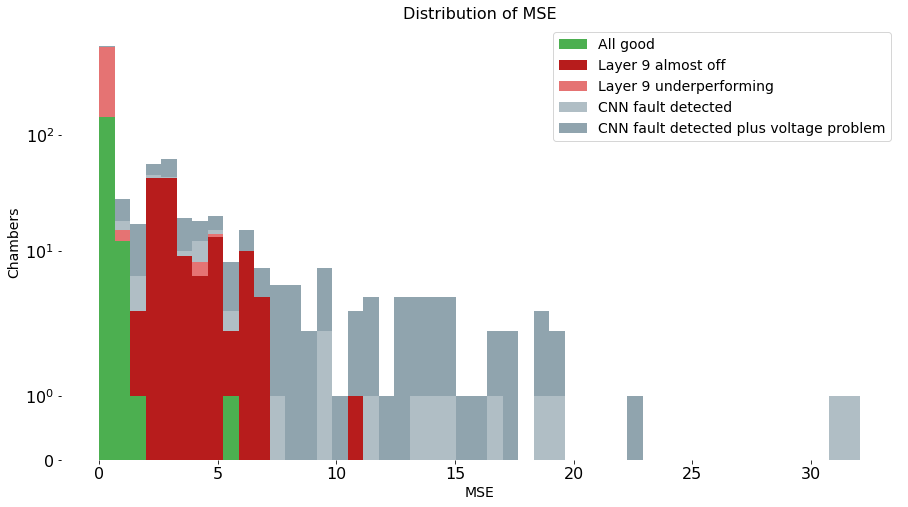

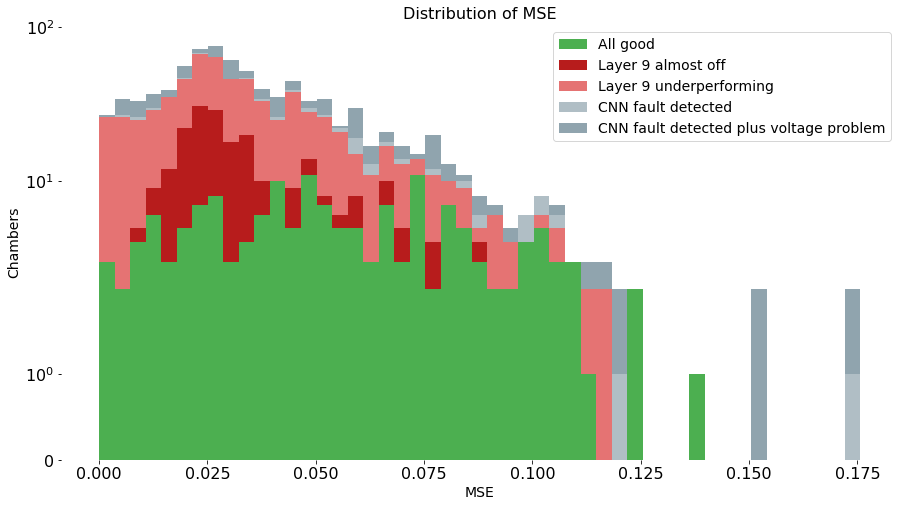

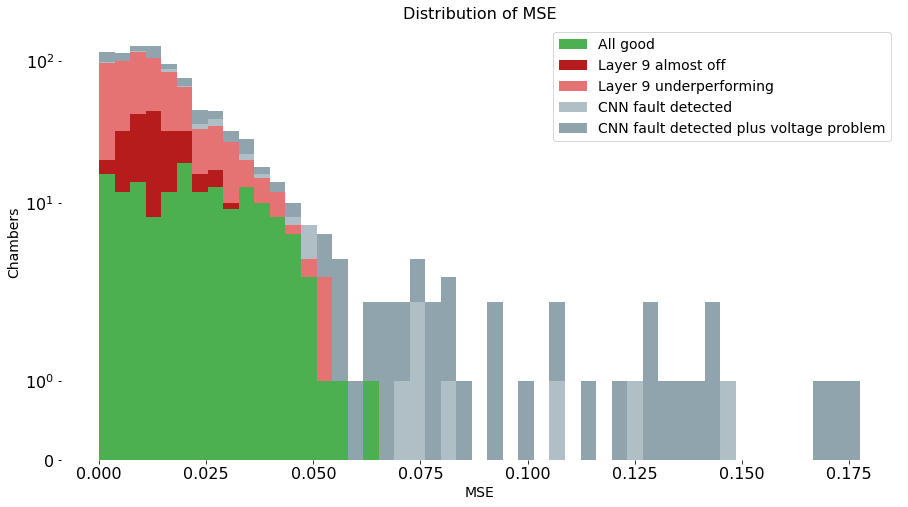

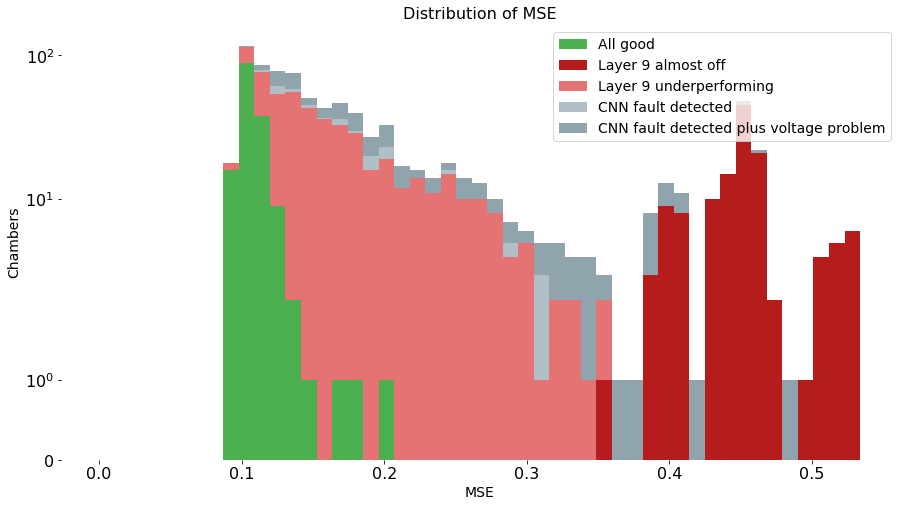

In [730]:
error_distribution("score_1_ae", 50)
error_distribution("score_3_ae", 50)
error_distribution("score_9_ae", 50)
error_distribution("distance_filip", 50)
error_distribution("distance_encoded_1_ae_max", 50)
error_distribution("score_1_ae_percent", 50)

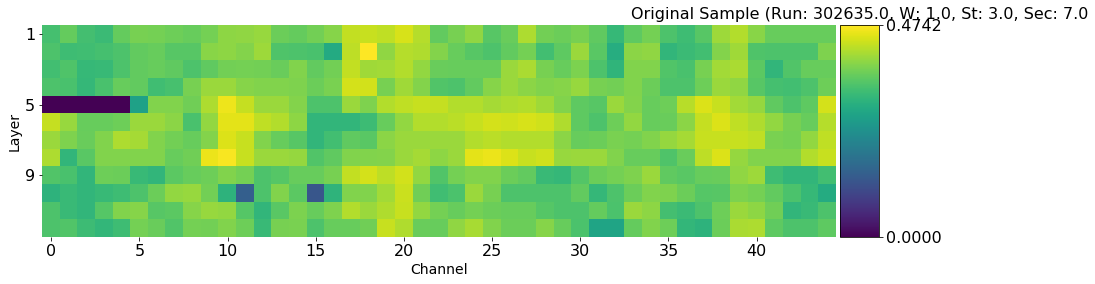

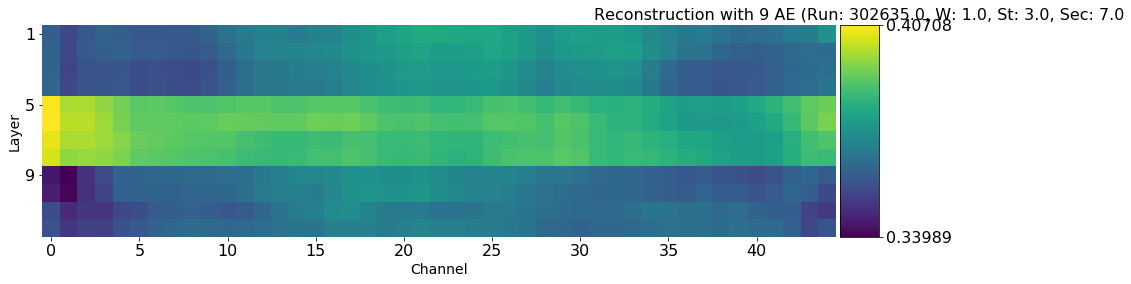

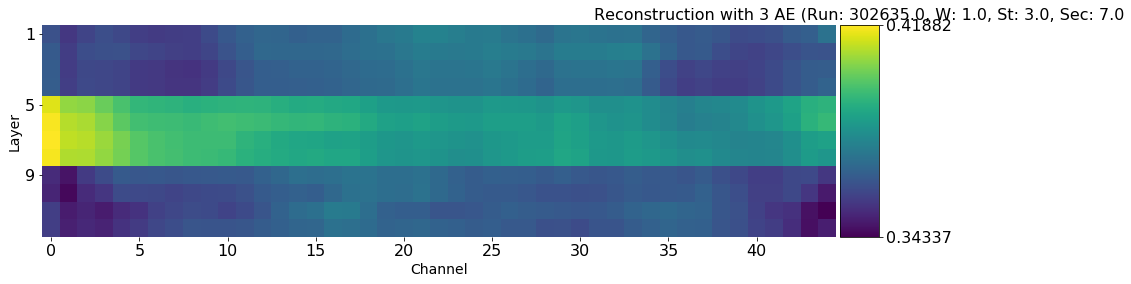

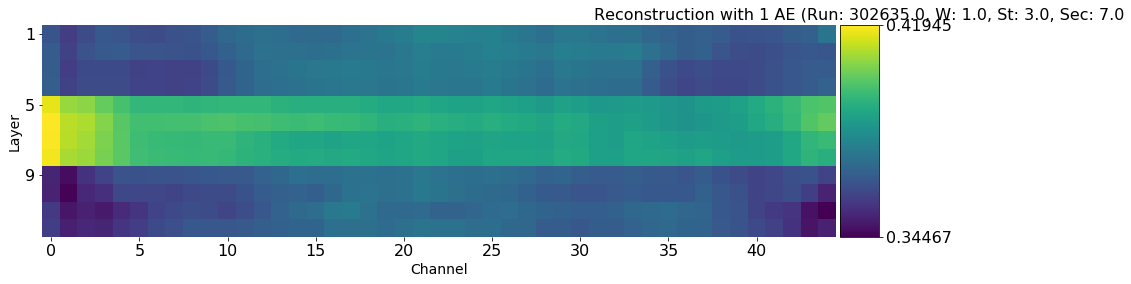

In [741]:
original_vs_reconstructed(drift_tubes_chambers[(drift_tubes_chambers.combined_score == -1)].sort_values('score_1_ae_percent', ascending=0).iloc[0])

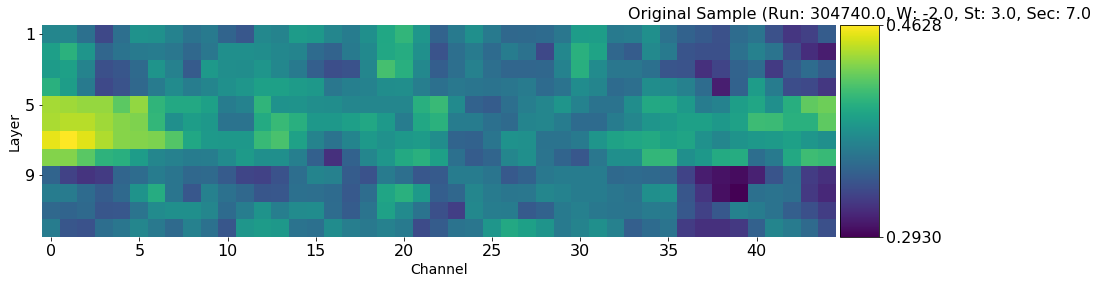

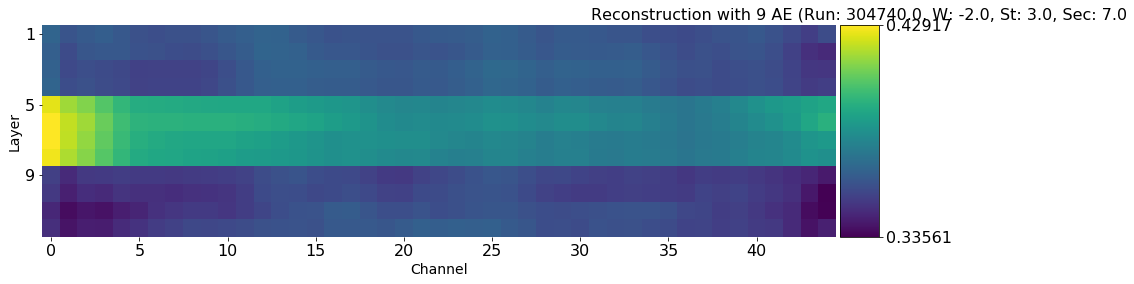

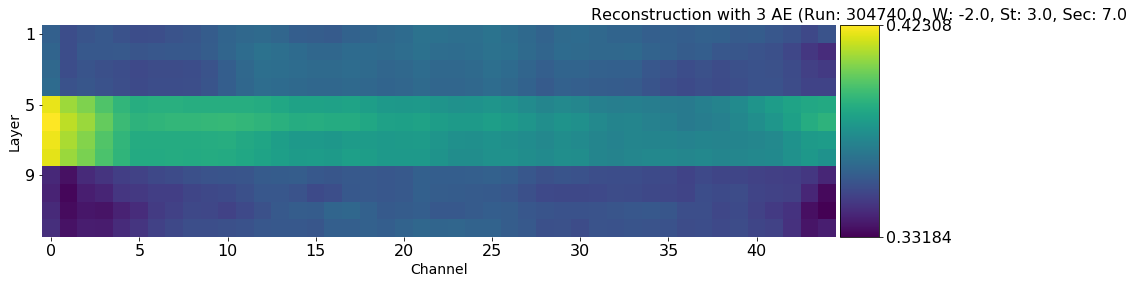

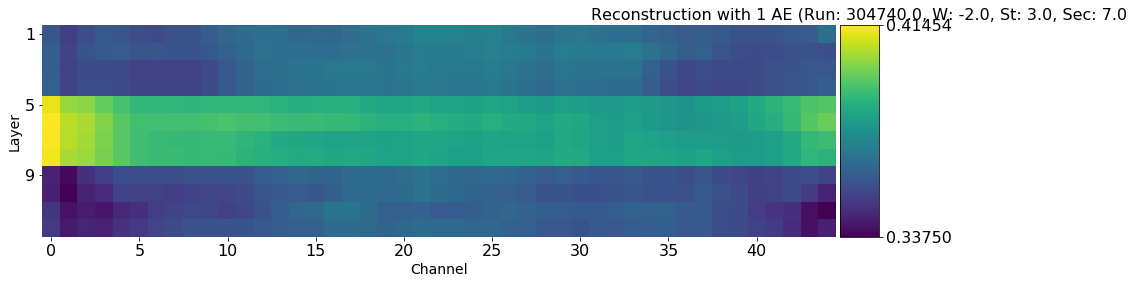

In [732]:
original_vs_reconstructed(drift_tubes_chambers[(drift_tubes_chambers.combined_score == 1) & (drift_tubes_chambers.run != 304739)].sort_values('score_1_ae_percent', ascending=1).iloc[0])

In [733]:
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers["station"] != 4)]

foo = np.array([])
for _ in test["content_raw"].values:
    _ = np.nanmean(_, axis=1)
    _ = _ / sum(_)
    foo = np.append(foo, -min(_))

drift_tubes_chambers.loc[test.index, "naive"] = pd.DataFrame({"naive": foo}, index=test.index)

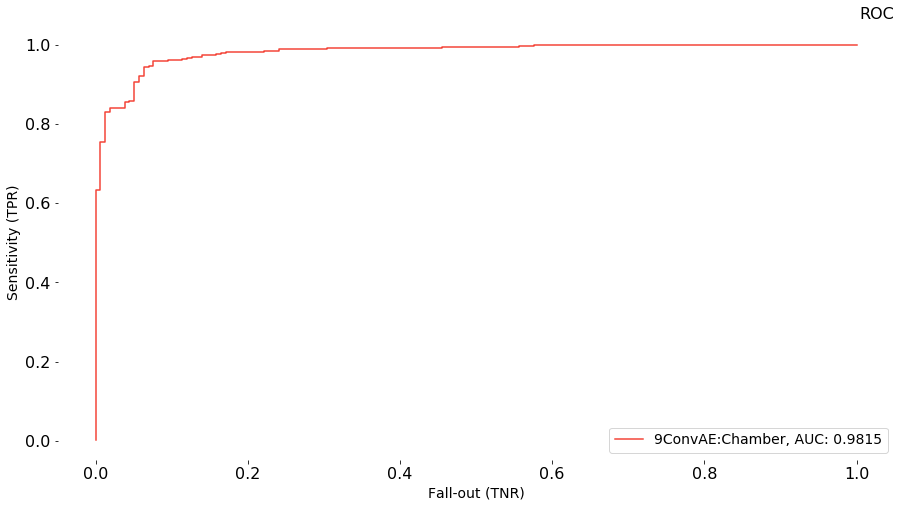

In [734]:
get_roc_curve(drift_tubes_chambers, 
              [("9ConvAE:Chamber", "naive", color_palette[0])],
             test_run)

In [735]:
drift_tubes_chambers[(drift_tubes_chambers.combined_score == -1)].sort_values('score_1_ae_percent', ascending=0).iloc[0]

content_powered_scaled       [[0.33519589901, 0.36163637042, 0.333364188671...
content_raw                  [[3.0, 3.0, 5.0, 5.0, 4.0, 3.0, 1.0, 5.0, 7.0,...
content_resized              [[3.77419, 4.86111, 3.70588, 3.32432, 4.87879,...
content_scaled               [[0.0261614788324, 0.0336956381798, 0.02568796...
content_smoothed             [[3.0, 5.0, 5.0, 4.0, 3.0, 3.0, 5.0, 5.0, 6.0,...
run                                                                     302635
score                                                                        0
sector                                                                       7
station                                                                      3
wheel                                                                        1
voltage_fault                                                               -1
combined_score                                                              -1
score_1_ae                                          

In [737]:
drift_tubes_layers[(drift_tubes_layers.run == 302635) &
                  (drift_tubes_layers.wheel == 1) &
                  (drift_tubes_layers.station == 3) &
                  (drift_tubes_layers.sector == 7) &
                  (drift_tubes_layers.layer == 5)
                  ]

,content,layer,lumi,run,sector,station,wheel,content_smoothed,content_resized,score,content_scaled,content_powered,content_powered_scaled
113444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, ...",5,1301,302635,7,3,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 6.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.84615, 6.0, 6.0, 5...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0127969365567, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.20193, 1.71177, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.270477890968, 0.38..."
